# Predicting Tax Valuation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.preprocessing import PolynomialFeatures

import warnings
warnings.filterwarnings('ignore')

import os
import env, acquire, prepare, features

## Visualizing Tax Rate Distribution
We begin by using our `acquire_cache_tax_data()` function to create a dataframe consisting of the tax rate for every record of interest. We are limiting our records to only those that meet the following requirements:
- Transaction Date between 2017-05-01 and 2017-06-30
- Property classified as one of the following Types:
    - Single Family Residential
    - Rural Residence
    - Mobile Home
    - Townhouse
    - Condominium
    - Row House
    - Bungalow
    - Manufactured, Modular, Prefabricated Homes
    - Patio Home
    - Inferred Single Family Residence

Tax rate is determined by the following formula:

    Tax Paid / Tax Value * 100 (rounded to 2 digits)

In [2]:
tax = acquire.acquire_cache_tax_data()

In [3]:
tax.head()

,taxrate,County
0,1.70,Los Angeles
1,1.53,Los Angeles
2,1.12,Orange
3,1.25,Los Angeles
4,1.19,Los Angeles


We split the dataframe into smaller ones representing each county

In [4]:
los_angeles_taxrate = tax[tax.County == 'Los Angeles'].taxrate
orange_taxrate = tax[tax.County == 'Orange'].taxrate
ventura_taxrate = tax[tax.County == 'Ventura'].taxrate

An initial histogram shows the following:
- The majority of the records are in Los Angeles county
- There is significant positive skew present in at least one of the counties, demonstrated by the large x-axis range
- The majority of the tax rates fall below 5%

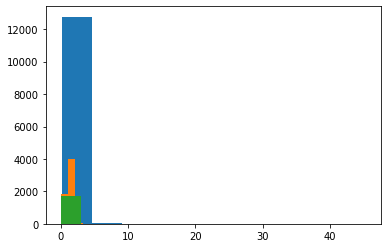

In [5]:
plt.hist(los_angeles_taxrate)
plt.hist(orange_taxrate)
plt.hist(ventura_taxrate)
plt.show()

Descriptive statistics of each county support our visual analysis. 

In [6]:
print(los_angeles_taxrate.describe())
print('\n')
print(orange_taxrate.describe())
print('\n')
print(ventura_taxrate.describe())

count    12807.000000
mean         1.380155
std          0.672991
min          0.110000
25%          1.210000
50%          1.250000
75%          1.390000
max         45.290000
Name: taxrate, dtype: float64


count    5845.000000
mean        1.205100
std         0.292402
min         0.010000
25%         1.050000
50%         1.150000
75%         1.260000
max        10.740000
Name: taxrate, dtype: float64


count    1711.000000
mean        1.212215
std         0.743119
min         0.080000
25%         1.070000
50%         1.120000
75%         1.190000
max        29.490000
Name: taxrate, dtype: float64


We create more meaningful visualizations of the distribution in each county
- Increase the number of bins
- Trim the x-axis to focus only on the region with the vast majority of observations
- Visualizing the mean and median for each region

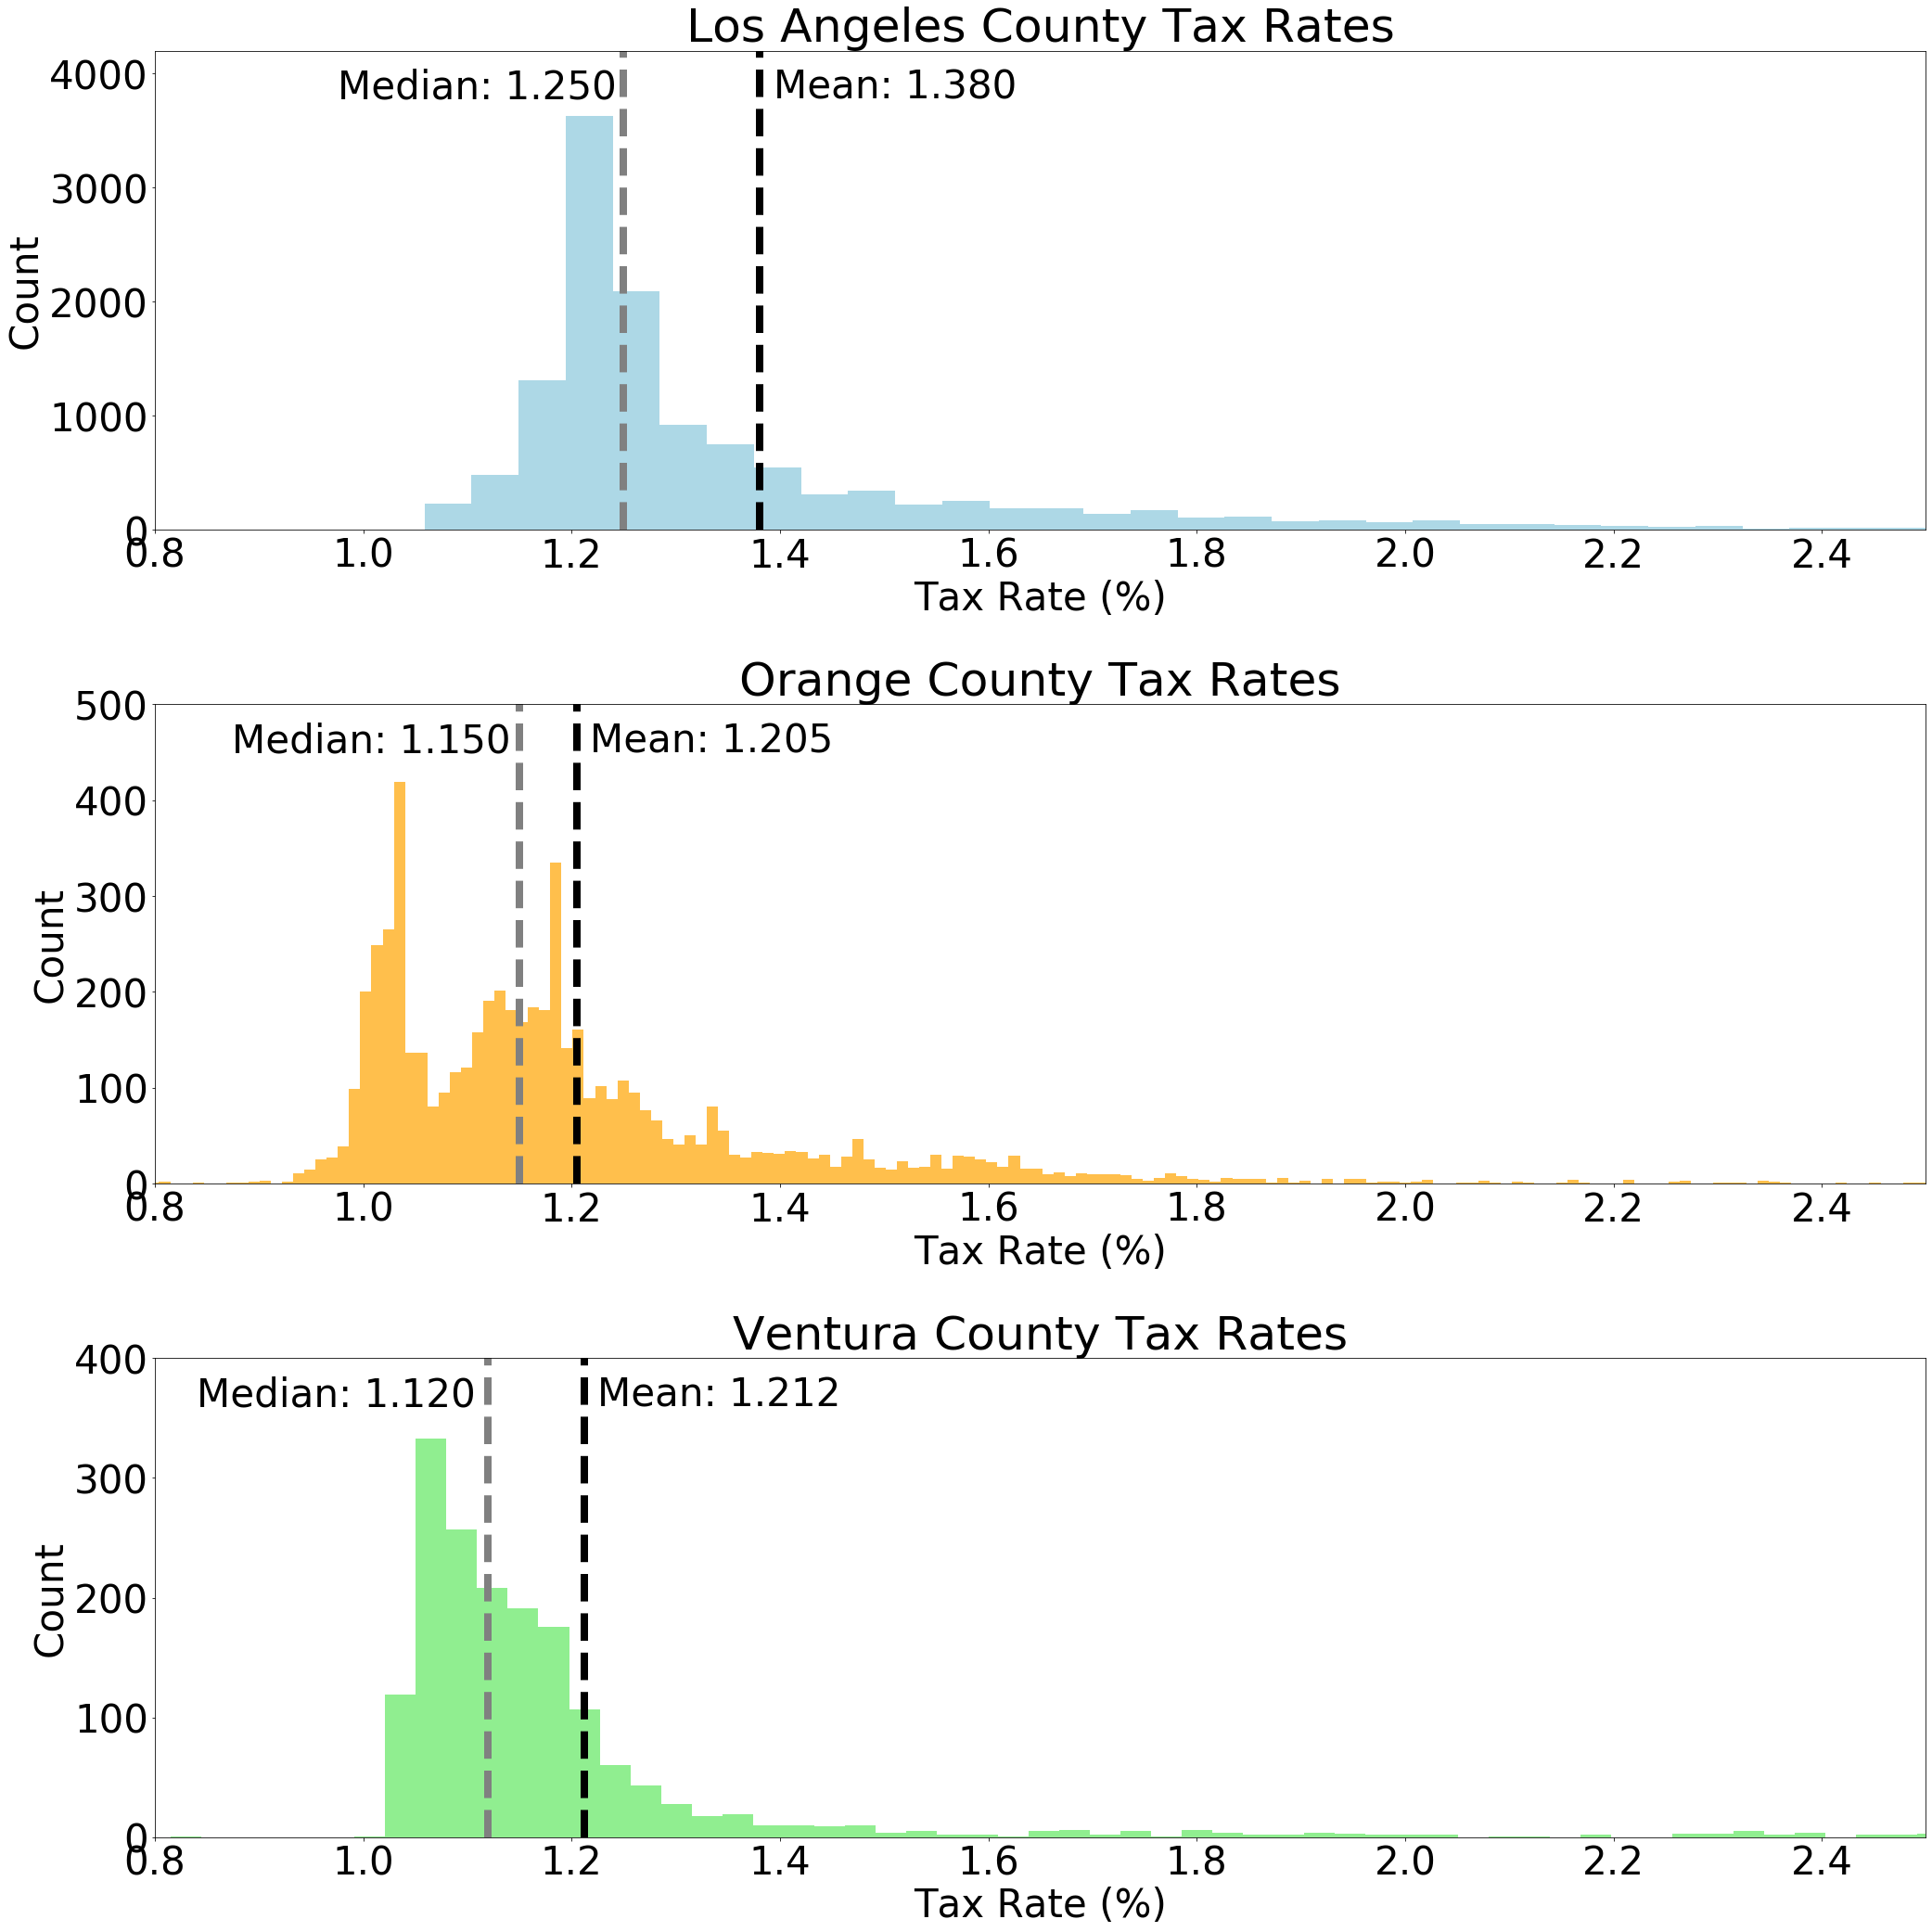

In [7]:
plt.rcParams.update({'font.size': 42}) # Sets global characteristics for font size

plt.figure(figsize=(30,30))
plt.subplot(3,1,1) # 
plt.hist(los_angeles_taxrate, bins = 1000, color = 'lightblue')
plt.xlim(0.8, 2.5) # Cropping range of x-axis
plt.ylim(0, 4200)
plt.title('Los Angeles County Tax Rates')
plt.ylabel('Count')
plt.xlabel('Tax Rate (%)')
min_ylim, max_ylim = plt.ylim()
plt.axvline(los_angeles_taxrate.mean(), color='k', linestyle='dashed', linewidth=8) # Creating visualization line for mean tax rate
plt.text(los_angeles_taxrate.mean()*1.01, max_ylim*0.9, 'Mean: {:.3f}'.format(los_angeles_taxrate.mean())) # Creating annotation for mean tax rate line
plt.axvline(los_angeles_taxrate.median(), color='gray', linestyle='dashed', linewidth=8) # Creating visualization line for median tax rate
plt.text(los_angeles_taxrate.median()*.78, max_ylim*0.9, 'Median: {:.3f}'.format(los_angeles_taxrate.median())) # Creating annotation for median tax rate line 

plt.subplot(3,1,2)
plt.hist(orange_taxrate, bins = 1000, color = 'orange', alpha = 0.7)
plt.xlim(0.8, 2.5)
plt.ylim(0, 500)
plt.title('Orange County Tax Rates')
plt.ylabel('Count')
plt.xlabel('Tax Rate (%)')
min_ylim, max_ylim = plt.ylim()
plt.axvline(orange_taxrate.mean(), color='k', linestyle='dashed', linewidth=8)
plt.text(orange_taxrate.mean()*1.01, max_ylim*0.9, 'Mean: {:.3f}'.format(orange_taxrate.mean()))
plt.axvline(orange_taxrate.median(), color='gray', linestyle='dashed', linewidth=8)
plt.text(orange_taxrate.median()*.76, max_ylim*0.9, 'Median: {:.3f}'.format(orange_taxrate.median()))

plt.subplot(3,1,3)
plt.hist(ventura_taxrate, bins = 1000, color = 'lightgreen')
plt.xlim(0.8, 2.5)
plt.ylim(0, 400)
plt.title('Ventura County Tax Rates')
plt.ylabel('Count')
plt.xlabel('Tax Rate (%)')
min_ylim, max_ylim = plt.ylim()
plt.axvline(ventura_taxrate.mean(), color='k', linestyle='dashed', linewidth=8)
plt.text(ventura_taxrate.mean()*1.01, max_ylim*0.9, 'Mean: {:.3f}'.format(ventura_taxrate.mean()))
plt.axvline(ventura_taxrate.median(), color='gray', linestyle='dashed', linewidth=8)
plt.text(ventura_taxrate.median()*.75, max_ylim*0.9, 'Median: {:.3f}'.format(ventura_taxrate.median()))

plt.tight_layout() # Reduces overlap of labels
# Uncomment the line below to save a .png of the visualization
# plt.savefig('county_tax_rates')
plt.show()

### Key Takeaways
- Mean tax rate is about 15% higher in Los Angeles county than in Orange or Venutra counties
- Orange county has the least positive skew, demonstrated by the smallest difference between the median and mean
- Los Angeles county has the most positive skew, demonstrated by the larger difference between the median and mean
- While there is a large range of tax rates, most tax rates fall between 1 and 2 percent

## Data Acquisition for Model
Our initial model consists of three features:
- `calculatedfinishedsquarefeet`
- `bathroomcnt`
- `bedroomcnt`

And one target variable:
- `taxvaluedollarcnt`

In [8]:
df = acquire.acquire_cache_data()
df.head()

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,taxvaluedollarcnt
0,1458.0,2.0,3.0,136104.0
1,1421.0,1.0,2.0,35606.0
2,2541.0,3.0,4.0,880456.0
3,1650.0,2.0,3.0,614000.0
4,693.0,1.0,2.0,274237.0


## Data Preparation
We begin by summarizing the data using the following functions:
- `df.info()`
- `df.describe()`
- `df.dtypes()`

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20364 entries, 0 to 20363
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   calculatedfinishedsquarefeet  20318 non-null  float64
 1   bathroomcnt                   20364 non-null  float64
 2   bedroomcnt                    20364 non-null  float64
 3   taxvaluedollarcnt             20364 non-null  float64
dtypes: float64(4)
memory usage: 636.5 KB


In [10]:
df.describe()

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,taxvaluedollarcnt
count,20318.000000,20364.000000,20364.000000,2.036400e+04
mean,1776.493208,2.284694,3.019839,5.054039e+05
std,936.606498,0.958072,1.030974,6.584038e+05
min,242.000000,0.000000,0.000000,1.050400e+04
25%,1176.000000,2.000000,2.000000,2.104808e+05
50%,1536.000000,2.000000,3.000000,3.665045e+05
75%,2102.000000,3.000000,4.000000,5.890250e+05
max,15450.000000,11.000000,12.000000,2.385837e+07


In [11]:
df.dtypes

calculatedfinishedsquarefeet    float64
bathroomcnt                     float64
bedroomcnt                      float64
taxvaluedollarcnt               float64
dtype: object

### Address Missing Values
- There are 46 null values in the `calculatedfinishedsquarefeet` feature
- There are 70 observations with `bathroomcnt` equal to 0
- There are 136 observations with `bedroomcnt` equal to 0 

In [12]:
df.calculatedfinishedsquarefeet.isnull().sum()

46

In [13]:
df[df.bathroomcnt == 0].shape

(70, 4)

In [14]:
df[df.bedroomcnt == 0].shape

(136, 4)

#### We will drop all observations with 0 or NaN values

In [15]:
mask_bathr = (df.bathroomcnt == 0) # Creates a boolean mask of True where bathroom count == 0
mask_bedr = (df.bedroomcnt == 0) # Creates a boolean mask of True where bedroom count == 0
mask_sf = df.calculatedfinishedsquarefeet.isnull() # Creates a boolean mask of True where there is a null value

mask = mask_bathr | mask_bedr | mask_sf # Creates a boolean mask based on any of the individual masks being true (| is an OR operator)
mask.sum()

df = df[-mask] # Creates a dataframe for all values that are not True in the boolean mask
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20223 entries, 0 to 20363
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   calculatedfinishedsquarefeet  20223 non-null  float64
 1   bathroomcnt                   20223 non-null  float64
 2   bedroomcnt                    20223 non-null  float64
 3   taxvaluedollarcnt             20223 non-null  float64
dtypes: float64(4)
memory usage: 790.0 KB


In [16]:
# Double check to make sure the code removed all the missing values.

bathr_missing = df[df.bathroomcnt == 0].shape[0]
bedr_missing = df[df.bedroomcnt == 0].shape[0]
sf_missing = df.calculatedfinishedsquarefeet.isnull().sum()

bathr_missing, bedr_missing, sf_missing

(0, 0, 0)

### Address Duplicates
- There are 58 duplicated observations
- These duplicates may be from "back-to-back" closing between three parties on the same transaction date. These additional observations are not meaningful and will add noise to our model. 
- We will drop these duplicates. 

In [17]:
df.duplicated().sum()

58

In [18]:
df = df.drop_duplicates(keep='first', ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20165 entries, 0 to 20164
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   calculatedfinishedsquarefeet  20165 non-null  float64
 1   bathroomcnt                   20165 non-null  float64
 2   bedroomcnt                    20165 non-null  float64
 3   taxvaluedollarcnt             20165 non-null  float64
dtypes: float64(4)
memory usage: 630.3 KB


In [19]:
df.describe()

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,taxvaluedollarcnt
count,20165.000000,20165.000000,20165.000000,2.016500e+04
mean,1780.902108,2.297595,3.041706,5.047822e+05
std,932.715302,0.948802,0.999601,6.554203e+05
min,242.000000,1.000000,1.000000,1.050400e+04
25%,1179.000000,2.000000,2.000000,2.107920e+05
50%,1540.000000,2.000000,3.000000,3.674520e+05
75%,2107.000000,3.000000,4.000000,5.900000e+05
max,15450.000000,11.000000,12.000000,2.385837e+07


## Visualization of Variables

#### Looking at the target variable
- Similar to the tax rate distributions explored earlier, the tax valuations are clustered below a median of $367,452 and are positively skewed by large valuations to the right

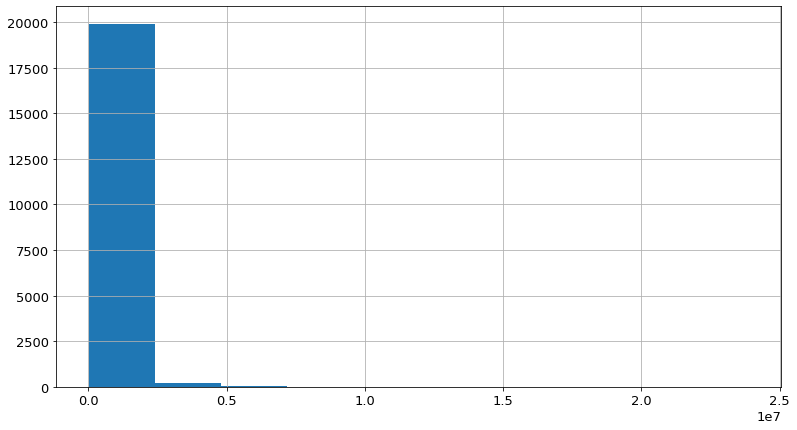

In [20]:
plt.rc('font',size=13)
plt.rc('figure', figsize=(13,7))

# Plot the distribution of the target variable: taxvaluedollarcnt

df.taxvaluedollarcnt.hist()

#### Looking at a pairplot of our variables

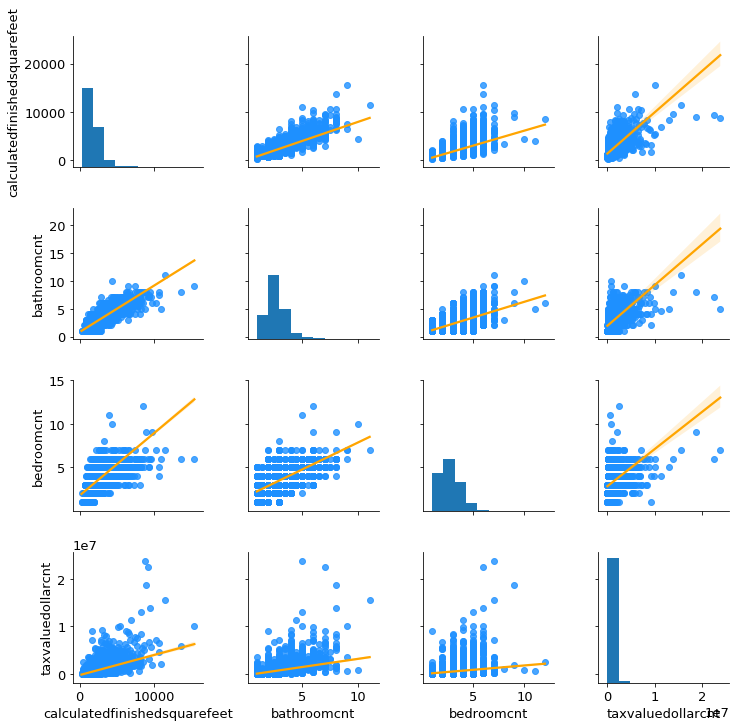

In [21]:
g = sns.PairGrid(df)
# we can specify any two functions we want for visualization
g.map_diag(plt.hist) # single variable
g.map_offdiag(sns.regplot, scatter_kws={"color": "dodgerblue"}, line_kws={"color": "orange"}) # interaction of two variables

#### Takeaways:
- There appears to be a positive correlation between all variables (risk for multicollinearity in our model)
- Distribution of all variables appears to be positively skewed
- Outliers in the `taxvaluedollarcnt` tend to sit above the regression lines for the independent variables rather than below. 

#### Looking at a box-plot of our variables

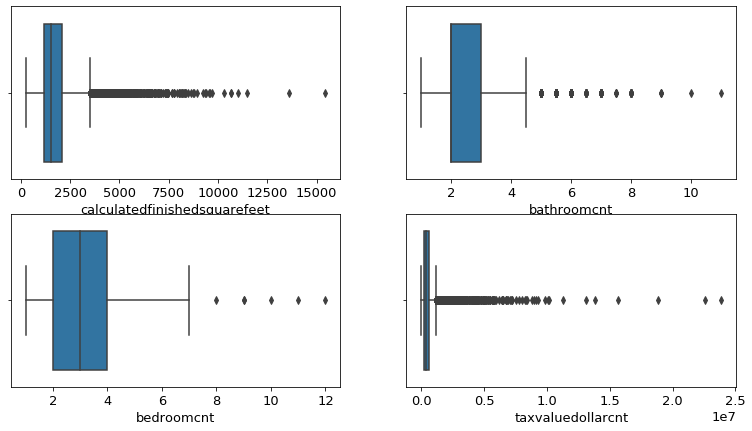

In [22]:
plt.subplot(221)
sns.boxplot(df.calculatedfinishedsquarefeet)

plt.subplot(222)
sns.boxplot(df.bathroomcnt)

plt.subplot(223)
sns.boxplot(df.bedroomcnt)

plt.subplot(224)
sns.boxplot(df.taxvaluedollarcnt)

#### Takeaways:
- For both `calculatedfinishedsquarefeet` and `taxvaluedollarcnt` both show a large number of observations above the interquartile range. 

### Splitting and Scaling The Data
- We will use our `prep_zillow()` function to split and scale the data
- `prep_zillow()` will divide the dataframe in to train, validate and test dataframes
- It will then fit a min-max scaler to the train dataframe, and apply that scaler to all three dataframes

In [23]:
df.head()

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,taxvaluedollarcnt
0,1458.0,2.0,3.0,136104.0
1,1421.0,1.0,2.0,35606.0
2,2541.0,3.0,4.0,880456.0
3,1650.0,2.0,3.0,614000.0
4,693.0,1.0,2.0,274237.0


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20165 entries, 0 to 20164
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   calculatedfinishedsquarefeet  20165 non-null  float64
 1   bathroomcnt                   20165 non-null  float64
 2   bedroomcnt                    20165 non-null  float64
 3   taxvaluedollarcnt             20165 non-null  float64
dtypes: float64(4)
memory usage: 630.3 KB


In [25]:
train_scaled, validate_scaled, test_scaled = prepare.prep_zillow(df) #prep_zillow() function
train_scaled.head()

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,taxvaluedollarcnt
16476,0.114492,0.111111,0.222222,0.017615
17919,0.126276,0.111111,0.222222,0.009729
3622,0.124049,0.111111,0.222222,0.006993
16863,0.112822,0.166667,0.111111,0.009475
15808,0.194470,0.222222,0.333333,0.012272


In [26]:
validate_scaled.head()

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,taxvaluedollarcnt
13876,0.261459,0.388889,0.333333,0.020078
6471,0.134348,0.111111,0.333333,0.028051
8096,0.072370,0.055556,0.222222,0.020477
95,0.358415,0.333333,0.555556,0.017081
4969,0.132214,0.111111,0.111111,0.039345


In [27]:
test_scaled.head()

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,taxvaluedollarcnt
18614,0.147152,0.222222,0.333333,0.038559
17346,0.047783,0.000000,0.111111,0.003003
7558,0.096957,0.166667,0.222222,0.011701
8780,0.142605,0.111111,0.222222,0.029557
8940,0.121451,0.111111,0.222222,0.016871


## Modeling
- MVP:
    - X: `'calculatedfinishedsquarefeet'`, `'bathroomcnt'`, `'bedroomcnt'`
    - y:  `taxvaluedollarcnt`

In [28]:
# Create X and y

X_train_scaled = train_scaled[['calculatedfinishedsquarefeet', 'bathroomcnt', 'bedroomcnt']]
y_train_scaled = train_scaled['taxvaluedollarcnt']

### Setting up a Baseline

In [29]:
mean, median = train_scaled.taxvaluedollarcnt.agg(['mean', 'median'])
mean, median 

(0.021679118375542906, 0.015692126737139968)

In [30]:
# Create an array of baseline predictions using mean

baseline = np.array([mean]*train_scaled.shape[0])
baseline[:5], len(baseline)

(array([0.02167912, 0.02167912, 0.02167912, 0.02167912, 0.02167912]), 14518)

In [31]:
# Compute baseline sse

baseline_residual = y_train_scaled - mean
baseline_sse = (baseline_residual**2).sum()
baseline_sse

11.533542707108785

In [32]:
# Compute baseline mse

baseline_mse = baseline_sse/train_scaled.shape[0]
baseline_mse

0.0007944305487745409

In [33]:
# Compute baseline rmse

baseline_rmse = mean_squared_error(y_train_scaled, baseline)**1/2
baseline_rmse

0.00039721527438727047

Note: These error values are small in magnitude because the target variable has been scaled by a min-max scaler. We will also use a scaled target when evaluating our model, so the relative difference in the error between the model and the baseline will still be preserved. 

## Compare 3 Different Algorithms for MVP
- LinearRegression
- LassoLars
- PolynomialFeatures + LinearRegression (2nd degree)

### Linear Regression

In [34]:
# Create, fit, predict and calculate the lm_rmse

lm = LinearRegression(normalize=True)
lm.fit(X_train_scaled, y_train_scaled)
lm_pred = lm.predict(X_train_scaled)
lm_rmse = mean_squared_error(y_train_scaled, lm_pred)**1/2

lm_rmse

0.00024919734598661327

In [35]:
# Does the model outperform baseline?
lm_rmse < baseline_rmse

True

### LassoLars

In [36]:
# Create, fit, predict and calculate the lars_rmse

lars = LassoLars(alpha=0.1)
lars.fit(X_train_scaled, y_train_scaled)
lars_pred = lars.predict(X_train_scaled)
lars_rmse = mean_squared_error(y_train_scaled, lars_pred)**1/2

lars_rmse

0.0003972152743872705

In [37]:
# Does the model outperform baseline?
lars_rmse < baseline_rmse

False

### PolynomialFeatures + LinearRegression
2nd degress polynomial

In [38]:
pf = PolynomialFeatures(degree=2)
X_train_scaled_squared = pf.fit_transform(X_train_scaled)

lm_squared = LinearRegression()
lm_squared.fit(X_train_scaled_squared, y_train_scaled)
lm_squared_pred = lm_squared.predict(X_train_scaled_squared)

lm_squared_rmse = mean_squared_error(y_train_scaled, lm_squared_pred)**1/2
lm_squared_rmse

0.00023320393387132827

In [39]:
# Does the model outperform baseline?
lm_squared_rmse < baseline_rmse

True

#### Takeaways:
- LinearRegression and LinearRegression with Polynomial Features outperform LassoLars
- LassoLars does not outperform our baseline

### Validate top 2 algorithms for MVP
- LinearRegression
- PolynomialFeatures + LinearRegression (2nd degree)

In [40]:
# Create X and y

X_validate_scaled = validate_scaled[['calculatedfinishedsquarefeet', 'bathroomcnt', 'bedroomcnt']]
y_validate_scaled = validate_scaled['taxvaluedollarcnt']

In [41]:
X_validate_scaled.head()

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt
13876,0.261459,0.388889,0.333333
6471,0.134348,0.111111,0.333333
8096,0.072370,0.055556,0.222222
95,0.358415,0.333333,0.555556
4969,0.132214,0.111111,0.111111


In [42]:
y_validate_scaled.head()

13876    0.020078
6471     0.028051
8096     0.020477
95       0.017081
4969     0.039345
Name: taxvaluedollarcnt, dtype: float64

### Validation of LinearRegression for MVP

In [43]:
lm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [44]:
lm_pred = lm.predict(X_validate_scaled)
lm_rmse = mean_squared_error(y_validate_scaled, lm_pred)**1/2

lm_rmse

0.000344478679726347

#### Takeaway:
- When the model is used on validate, the overall error increases, but it is still below the error of the baseline on train

### Validation of LinearRegression + Polynomial Features for MVP

In [45]:
pf

PolynomialFeatures(degree=2, include_bias=True, interaction_only=False,
                   order='C')

In [46]:
X_validate_scaled_squared = pf.transform(X_validate_scaled)
lm_squared_pred = lm_squared.predict(X_validate_scaled_squared)

lm_squared_rmse = mean_squared_error(y_validate_scaled, lm_squared_pred)**1/2
lm_squared_rmse

0.00030490635693139126

#### Takeaway:
- When the model is used on validate, the overall error increases, but it is still below the error of the baseline on train
- This model is still outperforming our Linear Regression model

# Feature Engineering and Additional Modeling
Now that we have our MVP developed, we spend time looking at additional features available in the dataset. Evaluation of these features may warrant the development of a new model.

In [47]:
df2 = acquire.get_zillow_data('2')
df2.head()

,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id.1,logerror,transactiondate
0,11289917,2061546,1.0,NaN,NaN,2.0,3.0,NaN,6.0,2.0,...,136104.0,2016.0,27214.0,2319.90,Y,15.0,6.037901e+13,1248,-0.362001,2017-06-23
1,11705026,1834372,NaN,NaN,NaN,1.0,2.0,NaN,6.0,1.0,...,35606.0,2016.0,23624.0,543.69,NaN,NaN,6.037232e+13,1772,-0.146056,2017-06-30
2,14269464,1923117,NaN,NaN,NaN,3.0,4.0,NaN,NaN,3.0,...,880456.0,2016.0,445569.0,9819.72,NaN,NaN,6.059064e+13,2028,0.021085,2017-06-01
3,11389003,2121349,NaN,NaN,NaN,2.0,3.0,NaN,6.0,2.0,...,614000.0,2016.0,449000.0,7673.19,NaN,NaN,6.037703e+13,3273,-0.325393,2017-06-01
4,11967869,2093710,NaN,NaN,NaN,1.0,2.0,NaN,5.0,1.0,...,274237.0,2016.0,191821.0,3267.47,NaN,NaN,6.037185e+13,3429,-0.005566,2017-06-29


Several columns have a large number of null values. We can evaluate the percentage of null values in each column.

In [48]:
# Compute the percentage of null values for each column. 

cols = df2.columns.tolist()
percentages = []
n_rows = df2.shape[0]

for col in cols:
    percentage = df2[col].isnull().sum()/n_rows
    percentages.append(percentage)
    
null_percentage = pd.DataFrame(percentages, index = cols)
null_percentage

,0
parcelid,0.000000
id,0.000000
airconditioningtypeid,0.680515
architecturalstyletypeid,0.997594
basementsqft,0.999460
...,...
taxdelinquencyyear,0.967344
censustractandblock,0.003781
id.1,0.000000
logerror,0.000000


We have set the limit for null values to 20%. Any column that is greater or equal to 20% null values will be dropped.

In [49]:
# Select all the cols that have less than 20% of null values

mask = null_percentage[0] < 0.2
null_percentage[mask].index.tolist()

['parcelid',
 'id',
 'bathroomcnt',
 'bedroomcnt',
 'calculatedbathnbr',
 'calculatedfinishedsquarefeet',
 'finishedsquarefeet12',
 'fips',
 'fullbathcnt',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'propertycountylandusecode',
 'propertylandusetypeid',
 'rawcensustractandblock',
 'regionidcity',
 'regionidcounty',
 'regionidzip',
 'roomcnt',
 'yearbuilt',
 'structuretaxvaluedollarcnt',
 'taxvaluedollarcnt',
 'assessmentyear',
 'landtaxvaluedollarcnt',
 'taxamount',
 'censustractandblock',
 'id.1',
 'logerror',
 'transactiondate']

We now have a collection of features that we can evaluate further for inclusion in an additional model.

In [50]:
# Selected features

# All of the features
features_target = ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
                   'fips', 'latitude', 'longitude', 'lotsizesquarefeet', 'propertycountylandusecode',
                   'rawcensustractandblock', 'regionidcity', 'regionidcounty','regionidzip',
                   'yearbuilt', 'censustractandblock', 'logerror', 'taxvaluedollarcnt']

# Only the independent variables
features = ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
            'fips', 'latitude', 'longitude', 'lotsizesquarefeet', 'propertycountylandusecode',
            'rawcensustractandblock', 'regionidcity', 'regionidcounty','regionidzip',
            'yearbuilt', 'censustractandblock', 'logerror']

# Only the dependent variable
target = ['taxvaluedollarcnt']

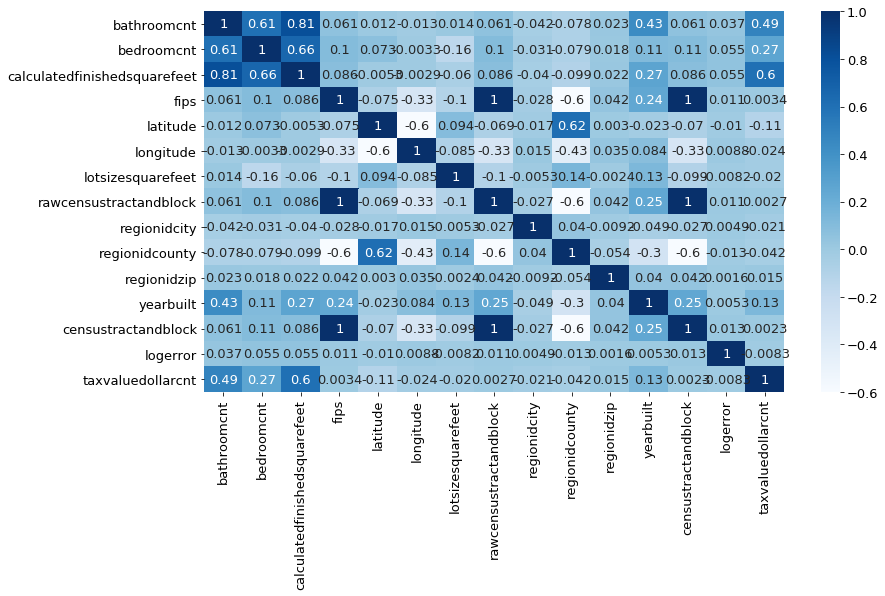

In [51]:
# corr_heatmap

df_vis = df2[features_target]
df_vis.head()

corr = df_vis.corr()
sns.heatmap(corr, cmap='Blues', annot=True)

#### Takeaways:
- The three features we used in our first model (`bathroomcnt`, `bedroomcnt`, `calculatedfinishedsquarefeet`) have the highest linear correlation with `taxvaluedollarcnt`
- Year build has a slight positive linear correlation with `taxvaluedollarcnt`
- As expected, there is a high degree of linear correlation between `bathroomcnt`, `bedroomcnt`, and `calculatedfinishedsquarefeet`
- There is also a perfect linear correlation between several variables. These variables are just different ways of describing the same characteristic. 
- Most of the regional data does not seem to have much of a linear correlation with `taxvaluedollarcnt`, but there still might be enough of a relationship there to improve the model by including these features. We will evaluate this further. 

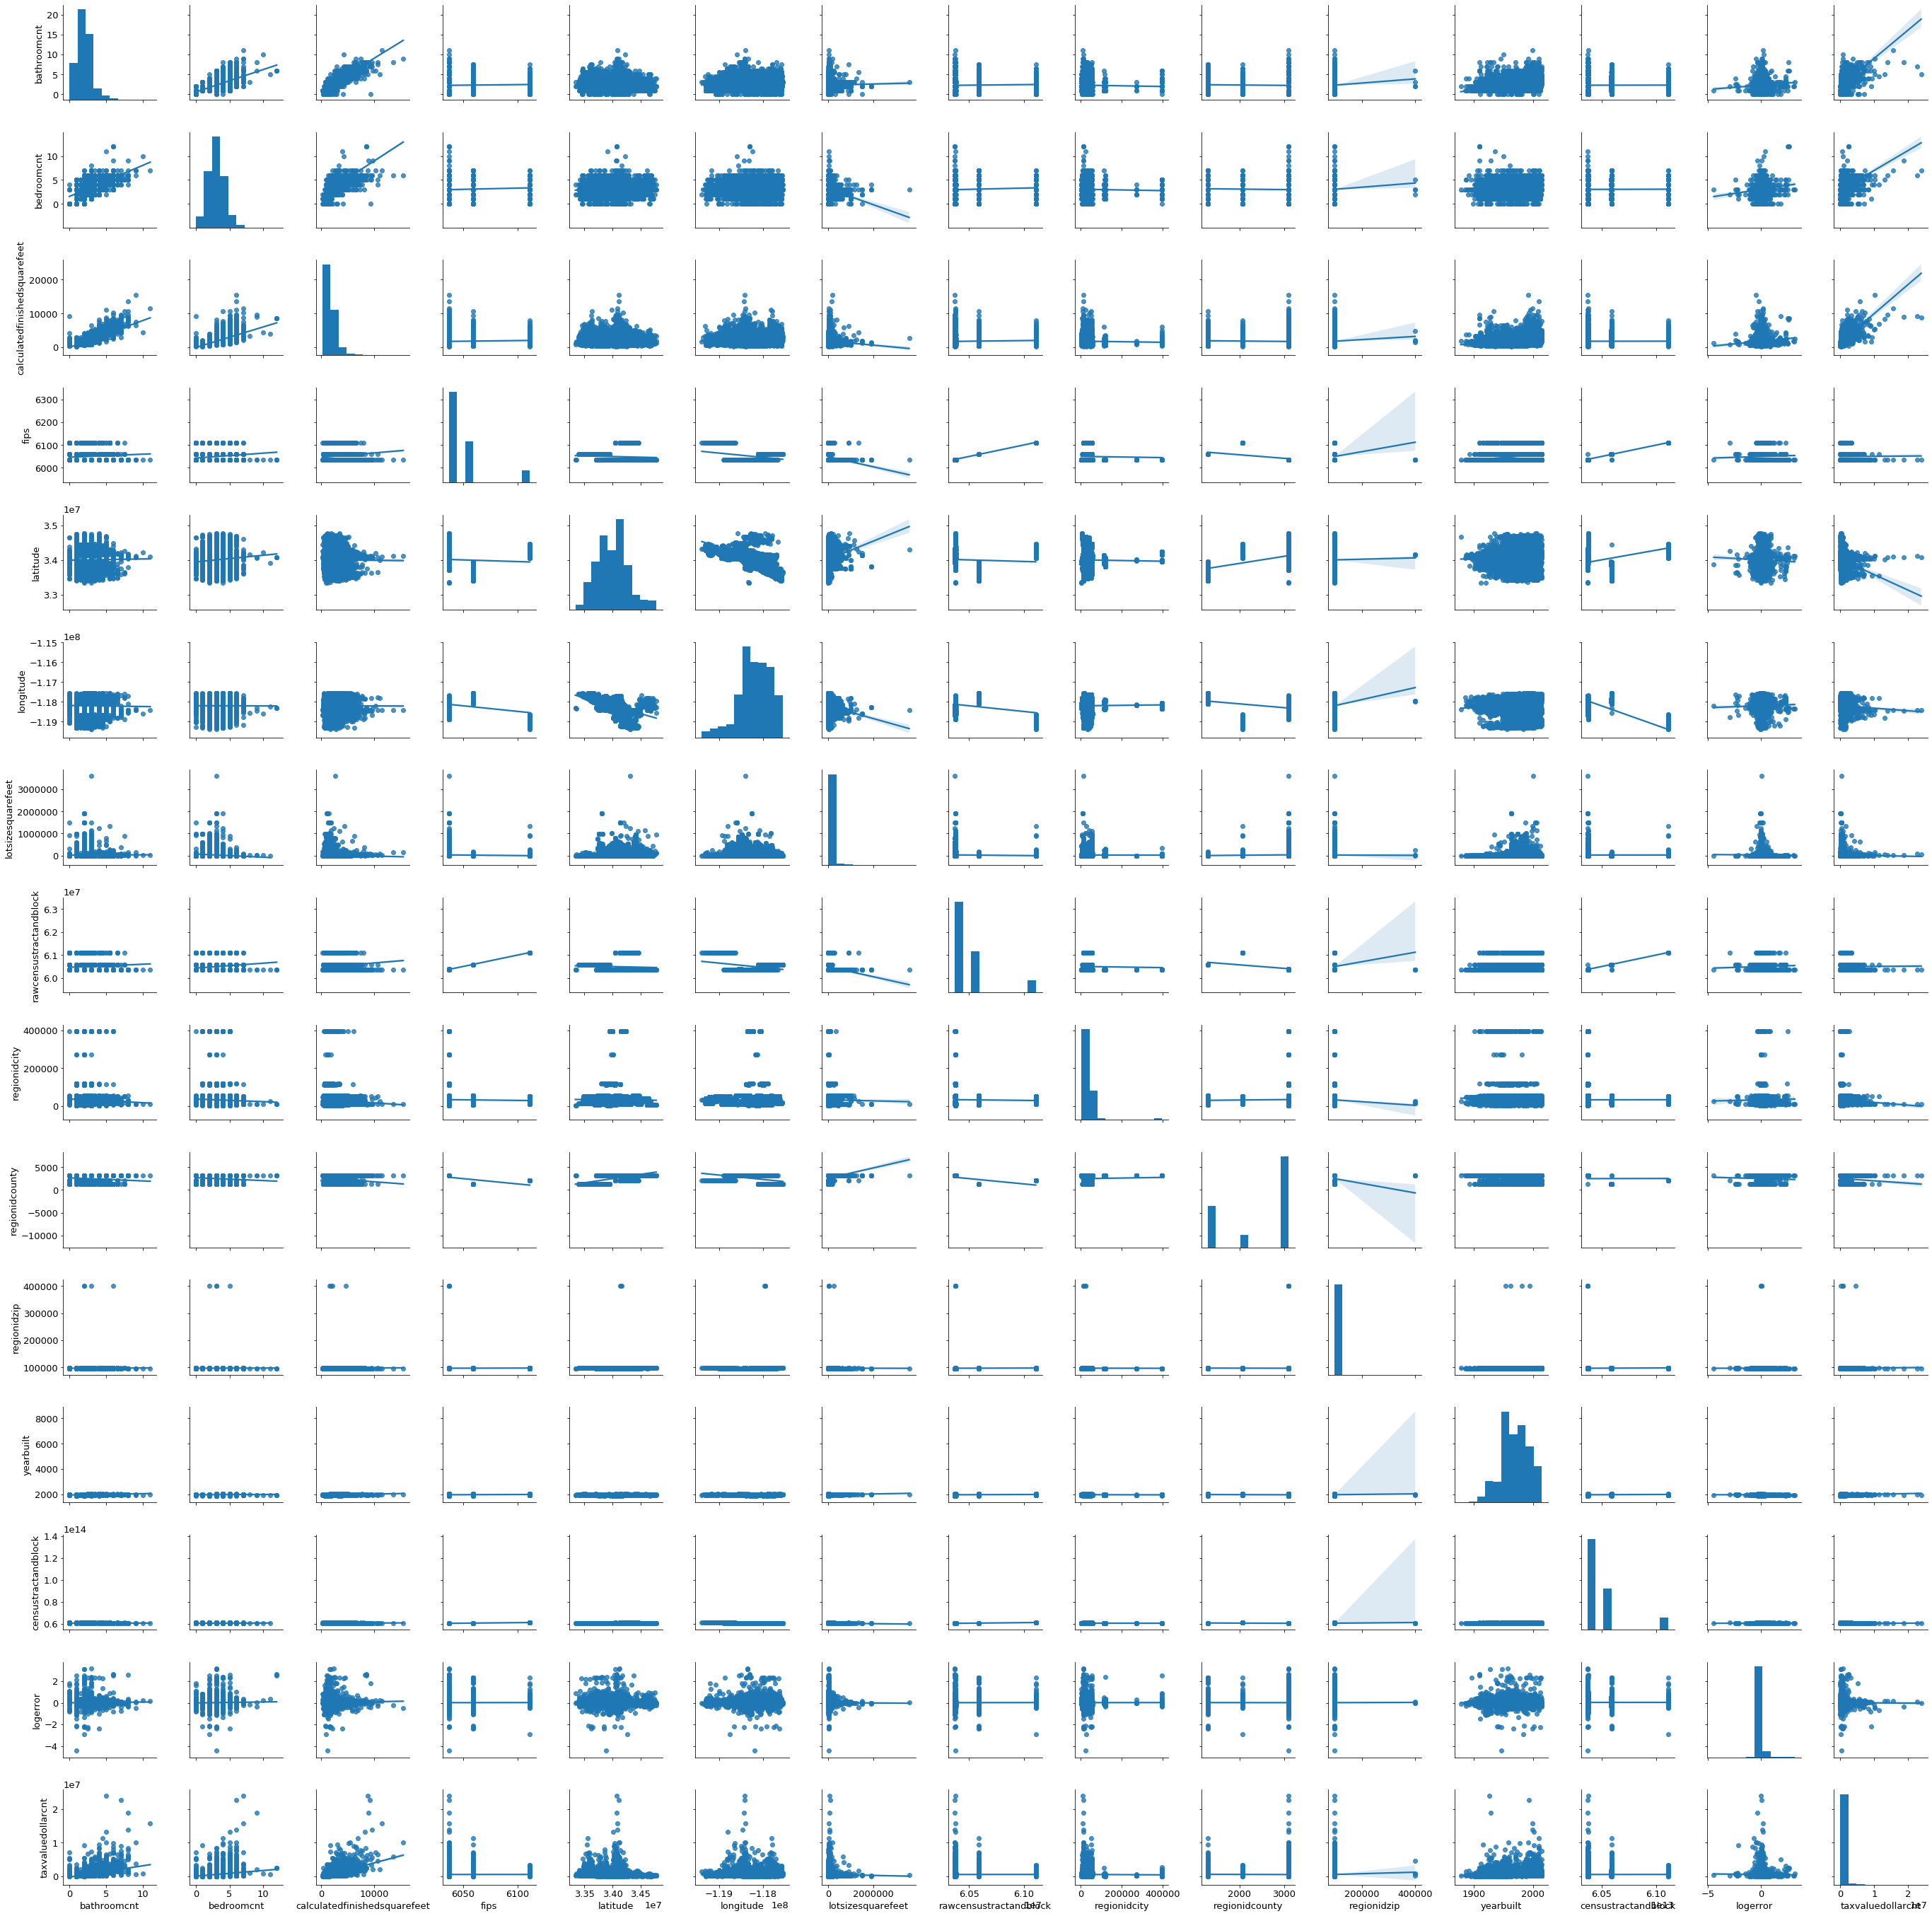

In [52]:
sns.pairplot(df_vis, kind='reg')

#### Takeaways:
While the correlation plot only checked for linear correlations, we can still see some patterns in the pairplot that may warrant the use of key variables in models:
- Outliers for tax value tend to fall above the line of best fit rather than below
- Not all fips codes are equal. We saw this in the intial visualization of tax distribution. Los Angeles County has a greater range in property tax value than the other counties. 
- While latitude and longitude does not have a linear correlation, there is evidence of clustering. Three groups of latitude and three groups of longitude have increased tax values.
- Year built shows a general positive correlation. There are also some outliers in older homes, but generally homes built before 1920 appear to have lower valuations. 

## Data Preparation
In order to create a model using the variables we have just reviewed, we will need to decide which variables can be included as they are, which can be included but will need to be modified in some way, and which should be dropped entirely. 

#### The goal of this next phase is to identify the features that we will evaluate with `SelectKBest` and `Recursive Feature Elimination`. 

Generally, we will do the following:
- Drop observations with missing values
- Drop duplicate observations

We have already identified in the correlation plot that there is too much multicollinearity between `fips` and `censustractandblock` and `rawcensustractandblock`. These three variables are describing the same characteristic. 

For this reason, `censustractandblock` and `rawcensustractandblock` are removed from consideration. 

In [53]:
# Create the dataframe that need to be wrangled

features = ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
            'fips', 'latitude', 'longitude',
            'lotsizesquarefeet', 'propertycountylandusecode', 'regionidcity', 
            'regionidcounty', 'regionidzip', 'yearbuilt', 
            'logerror']

target = ['taxvaluedollarcnt']

features_target = ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
                   'fips', 'latitude', 'longitude',
                   'lotsizesquarefeet', 'propertycountylandusecode', 'regionidcity', 
                   'regionidcounty', 'regionidzip', 'yearbuilt', 
                   'logerror', 
                   'taxvaluedollarcnt']

zillow2 = df2[features_target]
zillow2.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,regionidcity,regionidcounty,regionidzip,yearbuilt,logerror,taxvaluedollarcnt
0,2.0,3.0,1458.0,6037.0,34686163.0,-118113100.0,8284.0,0101,5534.0,3101.0,97318.0,1970.0,-0.362001,136104.0
1,1.0,2.0,1421.0,6037.0,33999877.0,-118291863.0,6707.0,0100,12447.0,3101.0,96018.0,1911.0,-0.146056,35606.0
2,3.0,4.0,2541.0,6059.0,33694636.0,-117912245.0,4975.0,1,38032.0,1286.0,96958.0,2003.0,0.021085,880456.0
3,2.0,3.0,1650.0,6037.0,33985377.0,-118361620.0,7300.0,0100,396550.0,3101.0,96037.0,1949.0,-0.325393,614000.0
4,1.0,2.0,693.0,6037.0,34112946.0,-118208106.0,2908.0,0100,12447.0,3101.0,96023.0,1921.0,-0.005566,274237.0


In [54]:
zillow2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20364 entries, 0 to 20363
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   20364 non-null  float64
 1   bedroomcnt                    20364 non-null  float64
 2   calculatedfinishedsquarefeet  20318 non-null  float64
 3   fips                          20364 non-null  float64
 4   latitude                      20364 non-null  float64
 5   longitude                     20364 non-null  float64
 6   lotsizesquarefeet             18104 non-null  float64
 7   propertycountylandusecode     20364 non-null  object 
 8   regionidcity                  19999 non-null  float64
 9   regionidcounty                20364 non-null  float64
 10  regionidzip                   20350 non-null  float64
 11  yearbuilt                     20302 non-null  float64
 12  logerror                      20364 non-null  float64
 13  t

In [55]:
# Drop the observations with missing values

cols = zillow2.columns.tolist()

for col in cols:
    mask = zillow2[col].isnull()
    zillow2 = zillow2[-mask]
    
zillow2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17721 entries, 0 to 20363
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   17721 non-null  float64
 1   bedroomcnt                    17721 non-null  float64
 2   calculatedfinishedsquarefeet  17721 non-null  float64
 3   fips                          17721 non-null  float64
 4   latitude                      17721 non-null  float64
 5   longitude                     17721 non-null  float64
 6   lotsizesquarefeet             17721 non-null  float64
 7   propertycountylandusecode     17721 non-null  object 
 8   regionidcity                  17721 non-null  float64
 9   regionidcounty                17721 non-null  float64
 10  regionidzip                   17721 non-null  float64
 11  yearbuilt                     17721 non-null  float64
 12  logerror                      17721 non-null  float64
 13  t

In [56]:
# Drop the duplicates

zillow2 = zillow2.drop_duplicates(keep='first', ignore_index=True)
zillow2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17720 entries, 0 to 17719
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   17720 non-null  float64
 1   bedroomcnt                    17720 non-null  float64
 2   calculatedfinishedsquarefeet  17720 non-null  float64
 3   fips                          17720 non-null  float64
 4   latitude                      17720 non-null  float64
 5   longitude                     17720 non-null  float64
 6   lotsizesquarefeet             17720 non-null  float64
 7   propertycountylandusecode     17720 non-null  object 
 8   regionidcity                  17720 non-null  float64
 9   regionidcounty                17720 non-null  float64
 10  regionidzip                   17720 non-null  float64
 11  yearbuilt                     17720 non-null  float64
 12  logerror                      17720 non-null  float64
 13  t

## Reviewing Categorical Variables
While we can include categorical variables in our final model through the use of dummy variables, the number of unique categories within a feature may make this not viable. Too many dimensions will cause the model to be unable to meaningfully find trends within the data and will lead to drastic overfitting. 

Lets look at the categorical variables we still are considering:

### fips
There are only three unique values for the `fips` variable. We can use this by creating dummy variables for each fips code. To further increase clarity, we will also convert the raw fips codes into their corresponding county name. 

`fips` will **be kept with modification**. 

In [57]:
zillow2.fips.value_counts()

6037.0    12222
6059.0     4085
6111.0     1413
Name: fips, dtype: int64

### regionidcounty
The value counts for this variable are identical to the value counts for `fips`. They are likely representing the same data, and if not, their risk for multicollinearity is too high to keep both variables. 

`regionidcounty` will **be dropped** from consideration. 

In [58]:
zillow2.regionidcounty.value_counts()

3101.0    12222
1286.0     4085
2061.0     1413
Name: regionidcounty, dtype: int64

### regionidzip
There are too many unique categories within this feature. While this feature could be used by binning values into regions based on domain expertise, this process is time consuming. 

`regionidzip` will **be dropped** from consideration

In [59]:
zillow2.regionidzip.value_counts().size

381

### regionidcity
Similar to regionidzip, there are too many unique categories to use dummy variables. Binning is too time consuming for now. 

`regionidcity` will **be dropped** from consideration

In [60]:
zillow2.regionidcity.value_counts().size

170

### propertycountylandusecode

Similar to regionidzip and regionidcity, there are too many unique categories to use dummy variables. While there may be some value in using this data for modeling, for now it would require a significant time committment to evaluate the influence of so many different categories. 

`propertycountylandusecode` will **be dropped** from consideration. 

In [61]:
zillow2.propertycountylandusecode.value_counts().size

28

### Modifying the Dataframe
Now that we know what our plan is with each variable, we can modify the dataframe to match our decisions.

In [62]:
# Dropping the unwanted features
zillow2.drop(columns = ['regionidcounty', 'propertycountylandusecode', 'regionidcity', 'regionidzip'], inplace=True)
zillow2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17720 entries, 0 to 17719
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   17720 non-null  float64
 1   bedroomcnt                    17720 non-null  float64
 2   calculatedfinishedsquarefeet  17720 non-null  float64
 3   fips                          17720 non-null  float64
 4   latitude                      17720 non-null  float64
 5   longitude                     17720 non-null  float64
 6   lotsizesquarefeet             17720 non-null  float64
 7   yearbuilt                     17720 non-null  float64
 8   logerror                      17720 non-null  float64
 9   taxvaluedollarcnt             17720 non-null  float64
dtypes: float64(10)
memory usage: 1.4 MB


In [63]:
# Convert fips to county names

zillow2.fips = zillow2.apply(acquire.add_county_column, axis=1)
zillow2.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,yearbuilt,logerror,taxvaluedollarcnt
0,2.0,3.0,1458.0,Los Angeles,34686163.0,-118113100.0,8284.0,1970.0,-0.362001,136104.0
1,1.0,2.0,1421.0,Los Angeles,33999877.0,-118291863.0,6707.0,1911.0,-0.146056,35606.0
2,3.0,4.0,2541.0,Orange,33694636.0,-117912245.0,4975.0,2003.0,0.021085,880456.0
3,2.0,3.0,1650.0,Los Angeles,33985377.0,-118361620.0,7300.0,1949.0,-0.325393,614000.0
4,1.0,2.0,693.0,Los Angeles,34112946.0,-118208106.0,2908.0,1921.0,-0.005566,274237.0


In [64]:
# Dummy encode fips, drop_first=False

def encode_label(df, columns_to_encode):
    """
    Dummy coding of categorical varibales
    Parameters: df, columns_to_encode(list)
    """
    obj_df = df[columns_to_encode]
    dummy_df = pd.get_dummies(obj_df, dummy_na=False)
    df = pd.concat([df, dummy_df], axis=1)
    df.drop(columns=columns_to_encode, inplace=True)
    return df

In [65]:
zillow2 = encode_label(zillow2, ['fips'])
zillow2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17720 entries, 0 to 17719
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   17720 non-null  float64
 1   bedroomcnt                    17720 non-null  float64
 2   calculatedfinishedsquarefeet  17720 non-null  float64
 3   latitude                      17720 non-null  float64
 4   longitude                     17720 non-null  float64
 5   lotsizesquarefeet             17720 non-null  float64
 6   yearbuilt                     17720 non-null  float64
 7   logerror                      17720 non-null  float64
 8   taxvaluedollarcnt             17720 non-null  float64
 9   fips_Los Angeles              17720 non-null  uint8  
 10  fips_Orange                   17720 non-null  uint8  
 11  fips_Ventura                  17720 non-null  uint8  
dtypes: float64(9), uint8(3)
memory usage: 1.3 MB


### Splitting and Scaling the Dataframe
We will split the dataframe into train, validate, and test sets. Then we will fit a min-max scaler function on our train dataset and transform all three datasets. This time we will not transform our target variable. 

In [66]:
#Splitting the data
train, validate, test = prepare.split_my_data(zillow2, pct=0.1)
train.shape, validate.shape, test.shape

((12758, 12), (3190, 12), (1772, 12))

In [67]:
# Create train, validate, test of X and y

X_train = train[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
                'latitude','longitude', 'lotsizesquarefeet',
                'yearbuilt', 'logerror', 'fips_Los Angeles', 
                'fips_Orange', 'fips_Ventura']]

y_train = train['taxvaluedollarcnt']

X_validate = validate[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
                'latitude','longitude', 'lotsizesquarefeet',
                'yearbuilt', 'logerror', 'fips_Los Angeles', 
                'fips_Orange', 'fips_Ventura']]

y_validate = validate['taxvaluedollarcnt']

X_test = test[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
                'latitude','longitude', 'lotsizesquarefeet',
                'yearbuilt', 'logerror', 'fips_Los Angeles', 
                'fips_Orange', 'fips_Ventura']]

y_test = test['taxvaluedollarcnt']

X_train.shape, X_validate.shape, X_test.shape

((12758, 11), (3190, 11), (1772, 11))

In [68]:
y_train.shape, y_validate.shape, y_test.shape

((12758,), (3190,), (1772,))

In [69]:
# Scale X_train, X_validate, X_test

scaler, X_train_scaled, X_validate_scaled, X_test_scaled = prepare.min_max_scaler(X_train, X_validate, X_test)

In [70]:
X_train_scaled.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,lotsizesquarefeet,yearbuilt,logerror,fips_Los Angeles,fips_Orange,fips_Ventura
2459,0.333333,0.272727,0.133943,0.542534,0.718569,0.002527,0.510949,0.435243,1.0,0.0,0.0
13744,0.222222,0.272727,0.081207,0.517055,0.811488,0.002176,0.547445,0.432752,1.0,0.0,0.0
15417,0.333333,0.272727,0.174448,0.894189,0.662560,0.033032,0.941606,0.438529,1.0,0.0,0.0
3257,0.111111,0.181818,0.036362,0.557093,0.810246,0.008068,0.737226,0.432060,1.0,0.0,0.0
3093,0.222222,0.181818,0.048133,0.606082,0.527087,0.001583,0.532847,0.421225,1.0,0.0,0.0


In [71]:
X_train_scaled.describe()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,lotsizesquarefeet,yearbuilt,logerror,fips_Los Angeles,fips_Orange,fips_Ventura
count,12758.000000,12758.000000,12758.000000,12758.000000,12758.000000,12758.000000,12758.000000,12758.000000,12758.000000,12758.000000,12758.000000
mean,0.255121,0.281934,0.103216,0.476539,0.644604,0.007683,0.646276,0.439618,0.687255,0.233814,0.078931
std,0.107351,0.091520,0.062761,0.182528,0.191221,0.025826,0.166089,0.029634,0.463630,0.423272,0.269641
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.222222,0.181818,0.062993,0.344153,0.530239,0.001508,0.540146,0.432177,0.000000,0.000000,0.000000
50%,0.222222,0.272727,0.087125,0.487103,0.659265,0.001919,0.635036,0.437727,1.000000,0.000000,0.000000
75%,0.333333,0.363636,0.125592,0.585368,0.785826,0.003234,0.773723,0.443588,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Exploration of Data
Now that we have reduced and modified our variables, we will explore the data in this dataframe. We can use our train dataset before the separation into X and y dataframes. 

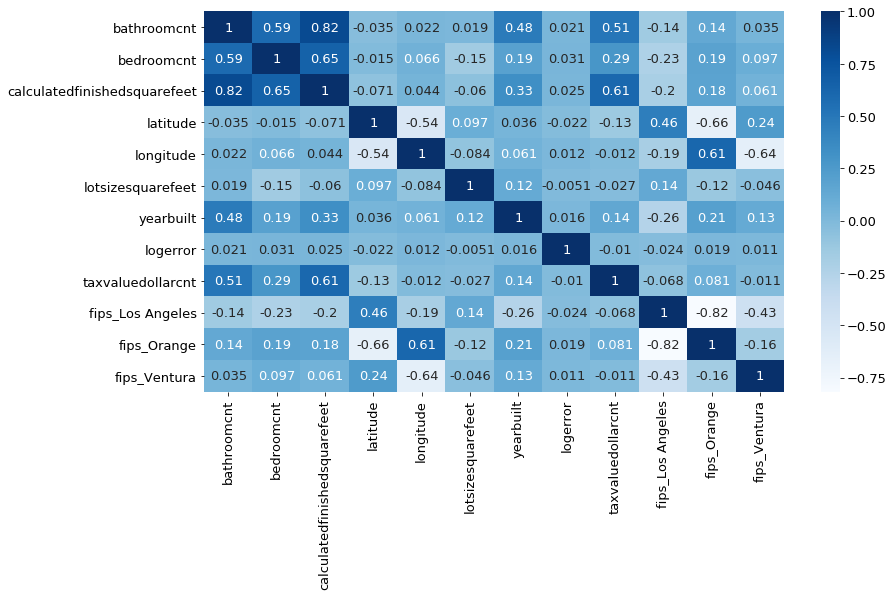

In [72]:
corr = train.corr()
sns.heatmap(corr, cmap='Blues', annot=True)

#### Takeaways:
- `bathroomcnt`, `bedroomcnt`, `calculatedfinishedsquarefeet` still show the highest correlation with `taxvaluedollarcnt` compared to all other variables
- `latitude` has a slight negative correlation. This is still similar to what we saw in the previous correlation plot, but it is more noticable now that much of the noise has been reduced. 
- `yearbuilt` still has a slight positive correlation.
- There is still multicollinearity between the regional data (`latitude` + `longitude` and `fips` dummies) but there may be enough distinct data there for us to use these features with each other in the final model.

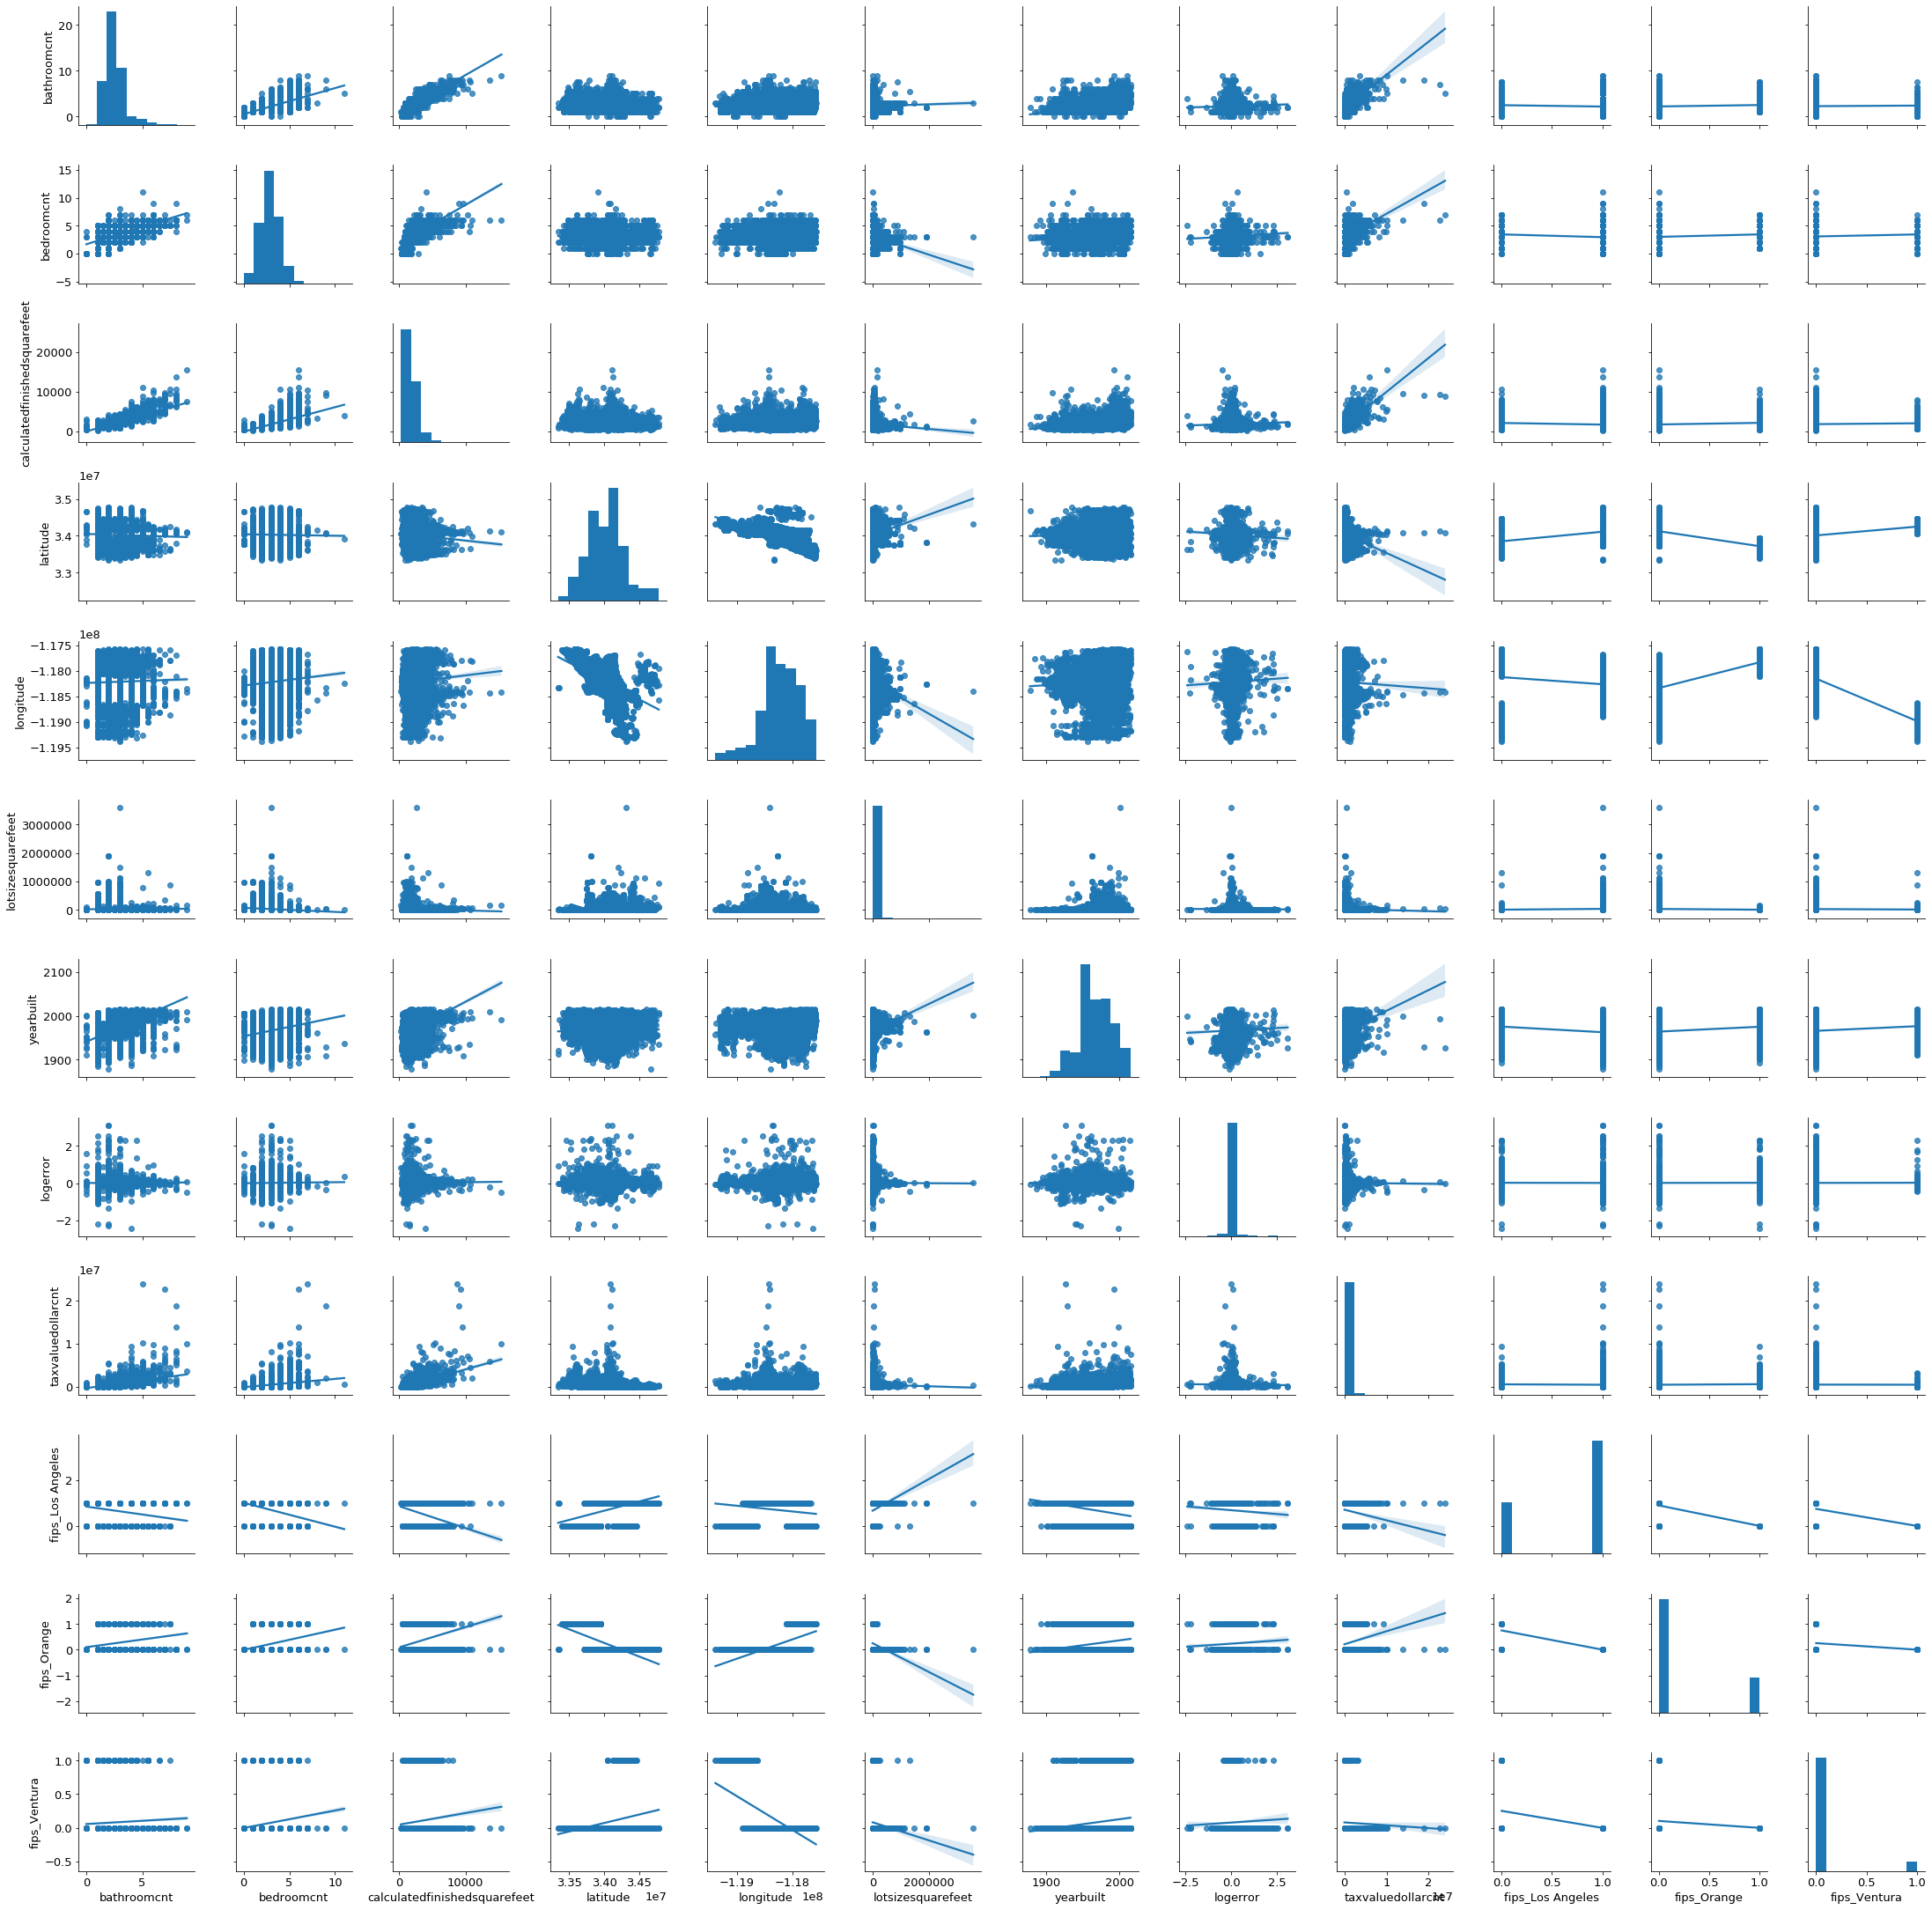

In [73]:
sns.pairplot(train, kind='reg')

#### Takeaways:
- There appears to be a meaningful relationship between `lotsizesquarefeet` and the `fips` regional data. Los Angeles County homes appear to have larger lot sizes than Orange County or Ventura County homes. 
- There is unsurprisingly a relationship between `longitude`, `latitude` and `fips` data. They all refer to the geographic location of the property. There may be some risk of multicollinearity here. 
- Although the correlation seems small, there is interestingly a correlation between `yearbuilt` and `fips` data. It looks like the newer homes seem to be found more often in Orange and Ventura counties. 
- It looks like there is a relationship between `taxvaluedollarcnt` and the `fips` county data, with the strongest relationships existing between `taxvaluedollarcnt` and Los Angeles and Orange counties. Given the relationship with the target variable, we will run statistical tests on these features.

## Hypothesis Testing
A notable difference between this dataset and the dataset we used for our MVP modeling is the inclusion of geographical data (notably fips data, which has a lot in common with our initial review of tax rate distributions). For this reason, we will evaluate if there is a significant difference between tax assessed property value in each of the counties compared to the mean. 

In [74]:
# Create masks values for three counties

mask_LA = train['fips_Los Angeles'] == 1
train_LA = train[mask_LA]

mask_orange = train['fips_Orange'] == 1
train_orange = train[mask_orange]

mask_ventura = train['fips_Ventura'] == 1
train_ventura = train[mask_ventura]

train_LA.shape, train_orange.shape, train_ventura.shape

((8768, 12), (2983, 12), (1007, 12))

### Hypothesis Test 1: Los Angeles County
$H_0$: The house values in Log Angeles county are the same as the average in three counties.  
$H_a$: The house values in Log Angeles county are different as the average in three counties.  
$alpha$ = 0.05

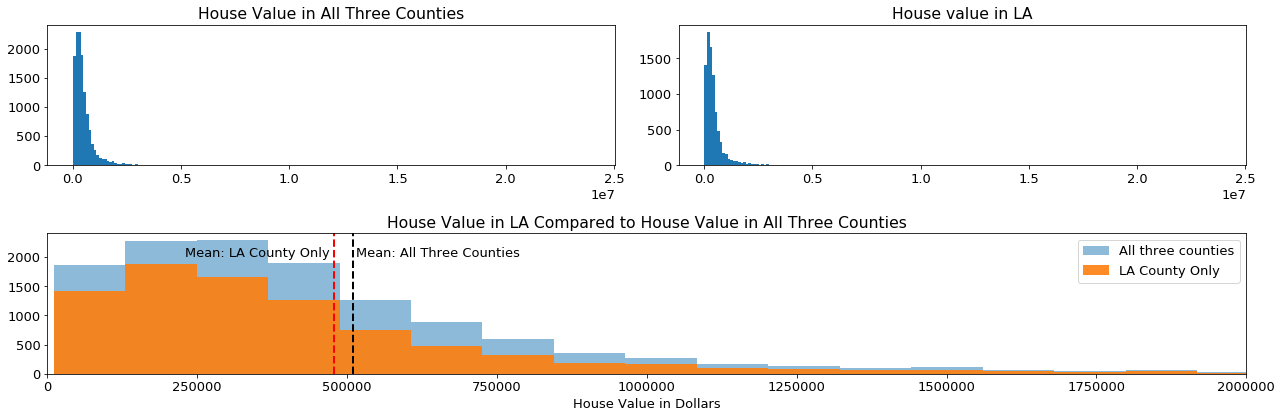

In [75]:
plt. figure(figsize=(18,6))

plt.subplot(2,2,1)

plt.hist(y_train, bins=200)
plt.title('House Value in All Three Counties')

plt.subplot(2,2,2)
plt.hist(train_LA.taxvaluedollarcnt, bins=200)
plt.title('House value in LA')

plt.subplot(2,1,2)
plt.hist(y_train, bins=200, label='All three counties', alpha = 0.5)
plt.hist(train_LA.taxvaluedollarcnt, bins=200, label='LA County Only', alpha = 0.9)
plt.axvline(y_train.mean(), color='k', linestyle='dashed', linewidth=2) # Creating visualization line for mean house value of all three counties
plt.text(y_train.mean()*1.01, 2000, 'Mean: All Three Counties') # Creating annotation for mean tax rate line
plt.axvline(train_LA.taxvaluedollarcnt.mean(), color='red', linestyle='dashed', linewidth=2) # Creating visualization line for median tax rate
plt.text(train_LA.taxvaluedollarcnt.mean()*.48, 2000, 'Mean: LA County Only')
plt.title('House Value in LA Compared to House Value in All Three Counties')
plt.xlabel('House Value in Dollars')
plt.xlim(0, 0.2*10**7)
plt.legend()
plt.tight_layout()
plt.show()

It is difficult to see if there is a significant difference from visualization alone, but the properties in LA County appear to have a lower tax assessed value than the mean of all three counties. This is in contrast to the apparent higher tax rate in Los Angeles county. Perhaps the municipality levies higher taxes to make up for the lower overall property values? Let us confirm if there is a significant difference between these two means.

In [76]:
from scipy import stats
# Run one-sample test
t, p = stats.ttest_1samp(train_LA.taxvaluedollarcnt, y_train.mean())
t, p

(-3.994981531051578, 6.522844766264357e-05)

#### Takeaways:
- p-value is well below $alpha$
- We reject the null hypothesis that there is no difference between the mean of LA County home values and the mean of all three counties home values. 

### Hypothesis Test Two: Orange County
$H_0$: The house values in Orange county are the same as the average in three counties.  
$H_a$: The house values in Orange county are different as the average in three counties.  
$alpha$ = 0.05


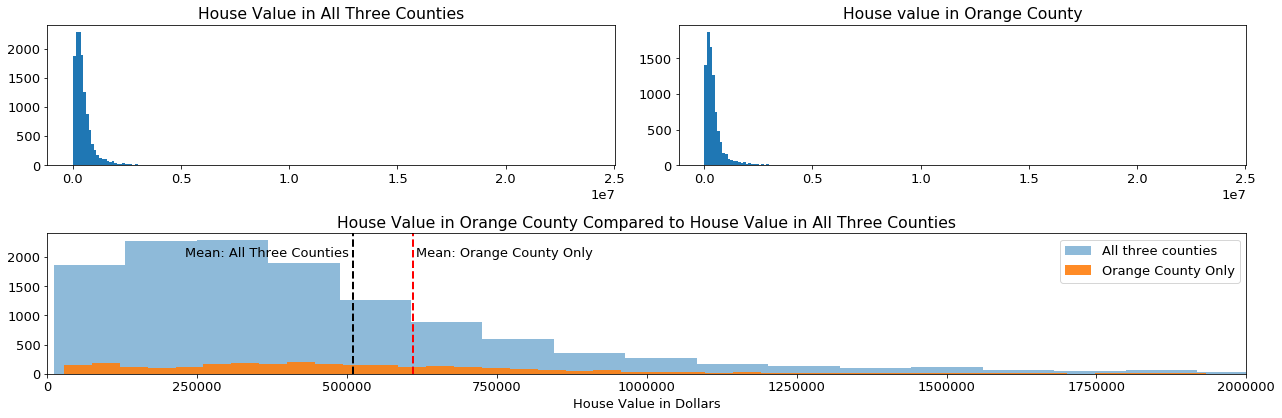

In [77]:
plt. figure(figsize=(18,6))

plt.subplot(2,2,1)

plt.hist(y_train, bins=200)
plt.title('House Value in All Three Counties')

plt.subplot(2,2,2)
plt.hist(train_LA.taxvaluedollarcnt, bins=200)
plt.title('House value in Orange County')

plt.subplot(2,1,2)
plt.hist(y_train, bins=200, label='All three counties', alpha = 0.5)
plt.hist(train_orange.taxvaluedollarcnt, bins=200, label='Orange County Only', alpha = 0.9)
plt.axvline(y_train.mean(), color='k', linestyle='dashed', linewidth=2) # Creating visualization line for mean house value of all three counties
plt.text(y_train.mean()*.45, 2000, 'Mean: All Three Counties') # Creating annotation for mean tax rate line
plt.axvline(train_orange.taxvaluedollarcnt.mean(), color='red', linestyle='dashed', linewidth=2) # Creating visualization line for median tax rate
plt.text(train_orange.taxvaluedollarcnt.mean()*1.01, 2000, 'Mean: Orange County Only')
plt.title('House Value in Orange County Compared to House Value in All Three Counties')
plt.xlabel('House Value in Dollars')
plt.xlim(0, 0.2*10**7)
plt.legend()
plt.tight_layout()
plt.show()

There appears to be a significant difference between the mean house value in Orange County compared to the mean of all three counties by visual inspection alone. Let us confirm if there is a significant difference between these two means.

In [78]:
t, p = stats.ttest_1samp(train_orange.taxvaluedollarcnt, y_train.mean())
t, p

(9.28687961088771, 2.971250881801298e-20)

#### Takeaways:
- p-value is well below $alpha$
- We reject the null hypothesis that there is no difference between the mean of Orange County home values and the mean of all three counties home values. 

### Hypothesis Test 3: Ventura County
$H_0$: The house values in Ventura county are the same as the average in three counties.  
$H_a$: The house values in Ventura county are different as the average in three counties.  
$alpha$ = 0.05

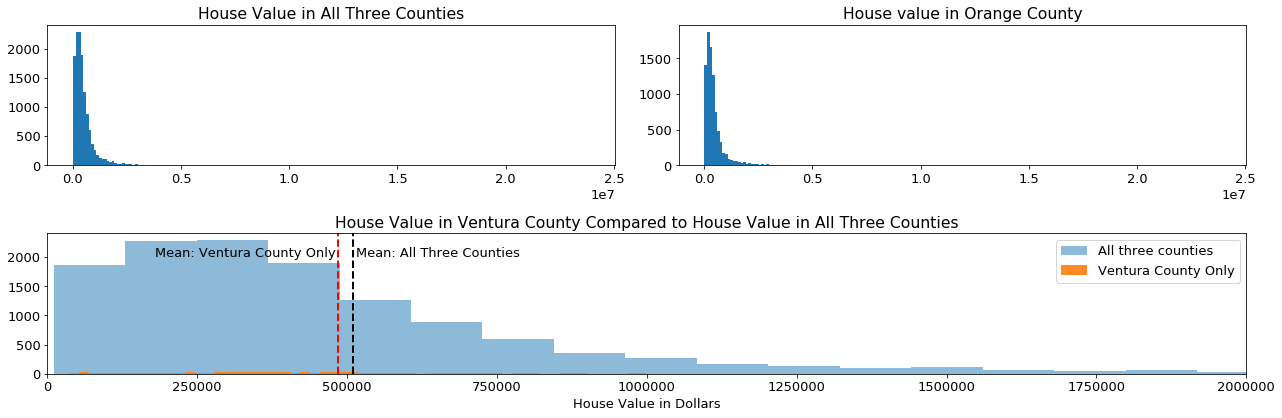

In [79]:
plt. figure(figsize=(18,6))

plt.subplot(2,2,1)

plt.hist(y_train, bins=200)
plt.title('House Value in All Three Counties')

plt.subplot(2,2,2)
plt.hist(train_LA.taxvaluedollarcnt, bins=200)
plt.title('House value in Orange County')

plt.subplot(2,1,2)
plt.hist(y_train, bins=200, label='All three counties', alpha = 0.5)
plt.hist(train_ventura.taxvaluedollarcnt, bins=200, label='Ventura County Only', alpha = 0.9)
plt.axvline(y_train.mean(), color='k', linestyle='dashed', linewidth=2) # Creating visualization line for mean house value of all three counties
plt.text(y_train.mean()*1.01, 2000, 'Mean: All Three Counties') # Creating annotation for mean tax rate line
plt.axvline(train_ventura.taxvaluedollarcnt.mean(), color='red', linestyle='dashed', linewidth=2) # Creating visualization line for median tax rate
plt.text(train_ventura.taxvaluedollarcnt.mean()*.37, 2000, 'Mean: Ventura County Only')
plt.title('House Value in Ventura County Compared to House Value in All Three Counties')
plt.xlabel('House Value in Dollars')
plt.xlim(0, 0.2*10**7)
plt.legend()
plt.tight_layout()
plt.show()

Although there appears to be a difference between Ventura County home values and the mean, the difference is much smaller than what we saw with the other counties. 

In [80]:
t, p = stats.ttest_1samp(train_ventura.taxvaluedollarcnt, y_train.mean())
t, p

(-2.2838439903955328, 0.022588394649575308)

#### Takeaways:
- p-value is well below $alpha$ (though it is not as small as the similar statistical tests done for the other counties)
- We reject the null hypothesis that there is no difference between the mean of Ventura County home values and the mean of all three counties home values. 

In [81]:
# Compute the variances in taxvaluedollarcnt in three counties

train_LA.taxvaluedollarcnt.var(), train_orange.taxvaluedollarcnt.var(), train_ventura.taxvaluedollarcnt.var()

(532316453170.5187, 344347658587.9691, 116278914677.73328)

#### Takeaways:
- Variance in the property values is highest in Los Angeles County and lowest in Ventura County

### Additional Hypothesis Testing
Now that we have confirmed that there are differences between the county means and the overall mean with respect to tax assessed property value, we can compare each county to each other.
#### Los Angeles County and Orange County
$H_0$: The house values in Los Angeles County are the same as Orange County.  
$H_a$: The house values in Los Angeles County are different than Orange County.  
$alpha$ = 0.05

In [82]:
t, p = stats.ttest_ind(train_LA.taxvaluedollarcnt, train_orange.taxvaluedollarcnt, equal_var=False)
t, p

(-9.863376684858562, 8.743834568493588e-23)

#### Takeaways
- We reject the null hypothesis that the house values are the same in both counties.
- The t-score shows that the values in Los Angeles County are lower than in Orange county. 

#### Ventura County and Orange County
$H_0$: The house values in Ventura County are the same as Orange County.  
$H_a$: The house values in Ventura County are different than Orange County.  
$alpha$ = 0.05

In [83]:
t, p = stats.ttest_ind(train_ventura.taxvaluedollarcnt, train_orange.taxvaluedollarcnt, equal_var=False)
t, p

(-8.181373319517133, 4.094549725804095e-16)

#### Takeaways
- We reject the null hypothesis that the house values are the same in both counties.
- The t-score shows that the values in Ventura County are lower than in Orange county.

#### Ventura County and Los Angeles County

$H_0$: The house values in Ventura County are the same as Los Angeles County.  
$H_a$: The house values in Ventura County are different than Los Angeles County.  
$alpha$ = 0.05

In [84]:
t, p = stats.ttest_ind(train_LA.taxvaluedollarcnt, train_ventura.taxvaluedollarcnt, equal_var=False)
t, p

(-0.49620562320223693, 0.6197973865417374)

#### Takeaways
- We **fail** to reject the null hypothesis that the house values are the same in both counties.

### Feature Selection
Now that we have evaluated our data set, we will utilize SelectKBest and Recursive Feature Elimination (RFE) to identify the best features to pass into our modelling phase.

In [85]:
import features

f_features = features.select_kbest(X_train_scaled, y_train, 6)
f_features

['bathroomcnt',
 'bedroomcnt',
 'calculatedfinishedsquarefeet',
 'latitude',
 'yearbuilt',
 'fips_Orange']

In [86]:
rfe_features = features.rfe(X_train_scaled, y_train, 6)
rfe_features

['bedroomcnt',
 'calculatedfinishedsquarefeet',
 'latitude',
 'fips_Los Angeles',
 'fips_Orange',
 'fips_Ventura']

#### Takeaways:
- We see some of the same features used for our MVP model in SelectKBest
- RFE eliminated bathroomcnt (possibly due to multicollinearity) and replaced year built with additional fips data
- Latitude is still present even with the fips data, which matches some of the clustering we saw in the pairplot for latitude. 

## Modeling
We can create models using the features from both SelectKBest and RFE and determine which algorithm produces better results. We will begin by setting up a baseline.

In [87]:
# Setting up baseline
mean, median = y_train.agg(['mean', 'median'])
mean, median

(509820.91950148926, 364401.0)

In [88]:
# Compute baseline prediction using mean

baseline = np.array([mean]*y_train.size)
baseline[:5], len(baseline)

(array([509820.91950149, 509820.91950149, 509820.91950149, 509820.91950149,
        509820.91950149]),
 12758)

In [89]:
# Compute baseline(mean) sse

baseline_residual = y_train - mean
baseline_sse = (baseline_residual**2).sum()
baseline_sse

5849440514532679.0

In [90]:
# Compute baseline(mean) mse

baseline_mse = baseline_sse/y_train.size
baseline_mse

458491966964.4677

In [91]:
# Compute baseline(mean) rmse

baseline_rmse = mean_squared_error(y_train, baseline)**1/2
baseline_rmse

229245983482.23386

## Compare 3 Different Algorithms for SelectKBest Features and RFE Features
- LinearRegression
- LassoLars
- Poly(2nd degree)

In [92]:
# Create X_train_scaled for f_features and rfe_features

X_train_scaled_f = X_train_scaled[f_features]
X_train_scaled_rfe = X_train_scaled[rfe_features]

In [93]:
 X_train_scaled_f.head(1) # SelectKBest chosen features

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,yearbuilt,fips_Orange
2459,0.333333,0.272727,0.133943,0.542534,0.510949,0.0


In [94]:
X_train_scaled_rfe.head(1) # RFE chosen features

,bedroomcnt,calculatedfinishedsquarefeet,latitude,fips_Los Angeles,fips_Orange,fips_Ventura
2459,0.272727,0.133943,0.542534,1.0,0.0,0.0


In [95]:
y_train.head(1) # Target variable

2459    1066356.0
Name: taxvaluedollarcnt, dtype: float64

In [96]:
def plot_residuals(actual, predicted, feature):
    """
    Returns the scatterplot of actural y in horizontal axis and residuals in vertical axis
    Parameters: actural y(df.se), predicted y(df.se), feature(str)
    Prerequisite: call function evaluate_slr
    """
    residuals = actual - predicted
    plt.hlines(0, actual.min(), actual.max(), ls=':')
    plt.scatter(actual, residuals)
    plt.ylabel('residual ($y - \hat{y}$)')
    plt.xlabel('actual value ($y$)')
    plt.title(f'Actual vs Residual on {feature}')
    return plt.gca()

In [97]:
def plot_residuals_percentage(actual, predicted, feature):
    """
    Returns the scatterplot of actural y in horizontal axis and residuals in vertical axis
    Parameters: actural y(df.se), predicted y(df.se), feature(str)
    Prerequisite: call function evaluate_slr
    """
    residuals = actual - predicted
    residuals_percentage = residuals/actual
    plt.hlines(0, actual.min(), actual.max(), ls=':')
    plt.scatter(actual, residuals_percentage)
    plt.ylabel('residual ($y - \hat{y}$)%')
    plt.xlabel('actual value ($y$)')
    plt.title(f'Actual vs Residual% on {feature}')
    return plt.gca()

### Linear Regression
- f_features (SelectKBest)
- rfe_features (RFE)

In [98]:
# Create lm object

lm2 = LinearRegression(normalize=True)
lm2

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [99]:
# Fit train dataset with f_features, predict and calculate the lm_rmse

lm_f = lm2.fit(X_train_scaled_f, y_train)
lm_pred_f = lm_f.predict(X_train_scaled_f)
lm_rmse_f = mean_squared_error(y_train, lm_pred_f)**1/2

lm_rmse_f

134918766070.42448

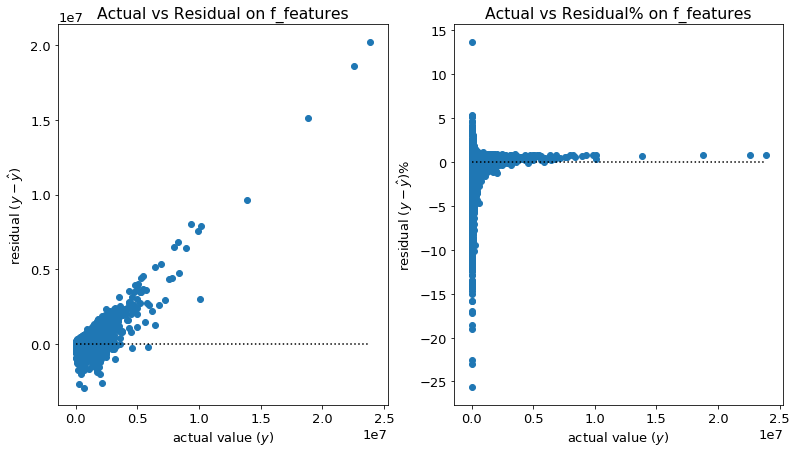

In [100]:
# Residual plot

plt.subplot(121)
plot_residuals(y_train, lm_pred_f, 'f_features')

plt.subplot(122)
plot_residuals_percentage(y_train, lm_pred_f, 'f_features')

Home values have such a large range that observation residuals as percentages helps us to identify where our model is actually performing the weakest. While high value outliers are driving RMSE, our model appears to have the most difficulty predicting lower value properties. We are tending to overestimate their values, likely due to the influence of high value outliers in the data.

In [101]:
# Fit train dataset with rfe_features, predict and calculate the lm_rmse

lm_rfe = lm2.fit(X_train_scaled_rfe, y_train)
lm_pred_rfe = lm_rfe.predict(X_train_scaled_rfe)
lm_rmse_rfe = mean_squared_error(y_train, lm_pred_rfe)**1/2

lm_rmse_rfe

136202202712.6829

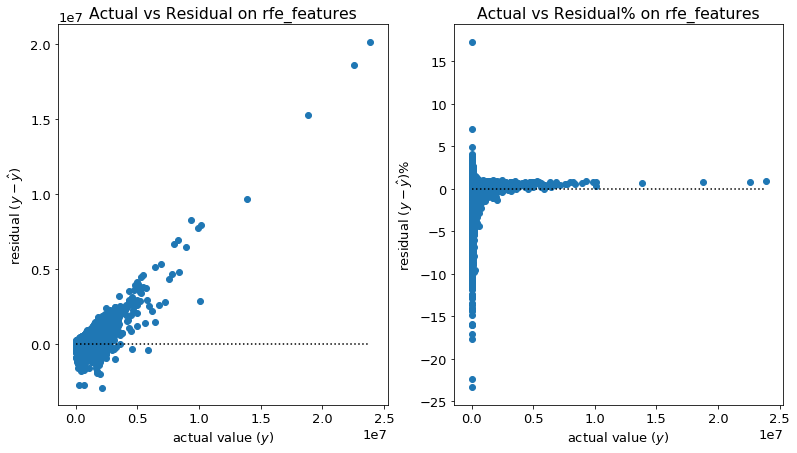

In [102]:
plt.subplot(121)
plot_residuals(y_train, lm_pred_rfe, 'rfe_features')

plt.subplot(122)
plot_residuals_percentage(y_train, lm_pred_rfe, 'rfe_features')

In [104]:
lm_rmse_rfe < lm_rmse_f # Does the model using RFE selected features perform better than the SelectKBest features?

False

The performance of both SelectKBest and RFE selected features are comparable with only a small difference in RMSE on the training data. 

### LassoLars
- f_features (SelectKBest)
- rfe_features (RFE)

In [105]:
# Create lars object (alpha=0.1) for 2nd iteration

lars2 = LassoLars(alpha=0.1)
lars2

LassoLars(alpha=0.1, copy_X=True, eps=2.220446049250313e-16, fit_intercept=True,
          fit_path=True, max_iter=500, normalize=True, positive=False,
          precompute='auto', verbose=False)

In [106]:
# Fit train dataset with f_features, predict and calculate the rmse

lars_f = lars2.fit(X_train_scaled_f, y_train)
lars_pred_f = lars_f.predict(X_train_scaled_f)
lars_rmse_f = mean_squared_error(y_train, lars_pred_f)**1/2

lars_rmse_f

134918766887.39528

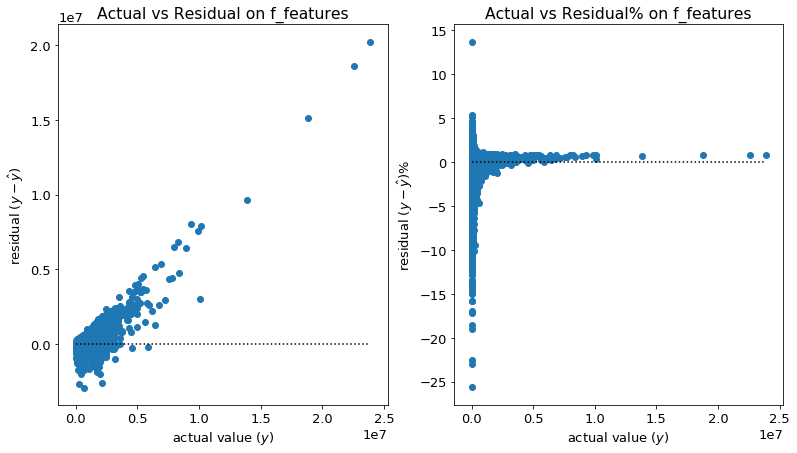

In [107]:
plt.subplot(121)
plot_residuals(y_train, lars_pred_f, 'f_features')

plt.subplot(122)
plot_residuals_percentage(y_train, lars_pred_f, 'f_features')

In [108]:
# Fit train dataset with rfe_features, predict and calculate the lm_rmse

lars_rfe = lars2.fit(X_train_scaled_rfe, y_train)
lars_pred_rfe = lars_rfe.predict(X_train_scaled_rfe)
lars_rmse_rfe = mean_squared_error(y_train, lars_pred_rfe)**1/2

lars_rmse_rfe

136201429479.60452

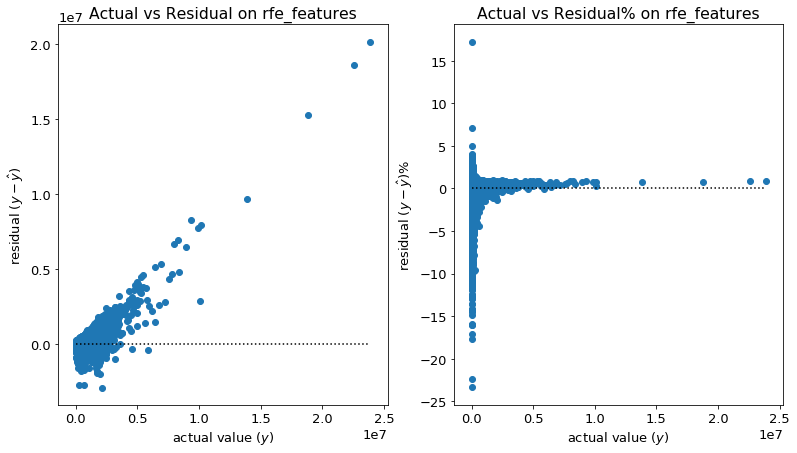

In [109]:
plt.subplot(121)
plot_residuals(y_train, lars_pred_rfe, 'rfe_features')

plt.subplot(122)
plot_residuals_percentage(y_train, lars_pred_rfe, 'rfe_features')

In [110]:
lars_rmse_rfe < lars_rmse_f # Does the model using RFE selected features perform better than the SelectKBest features?

False

The performance of both SelectKBest and RFE selected features are comparable with only a small difference in RMSE on the training data.

### Linear Regression with Polynomial Features (2nd Degree)
- f_features (SelectKBest)
- rfe_features (RFE)

In [111]:
# Transform X_train_scaled_f and _rfe to squared.

pf2 = PolynomialFeatures(degree=2)
X_train_scaled_squared_f = pf2.fit_transform(X_train_scaled_f)
X_train_scaled_squared_rfe = pf2.fit_transform(X_train_scaled_rfe)

In [112]:
# Create lm_squared object

lm_squared2 = LinearRegression()

In [113]:
# Fit X_train_scaled_squared_f, predict and compute the rmse

lm_squared_f = lm_squared2.fit(X_train_scaled_squared_f, y_train)
lm_squared_pred_f = lm_squared_f.predict(X_train_scaled_squared_f)

lm_squared_rmse_f = mean_squared_error(y_train, lm_squared_pred_f)**1/2
lm_squared_rmse_f

119325142286.75302

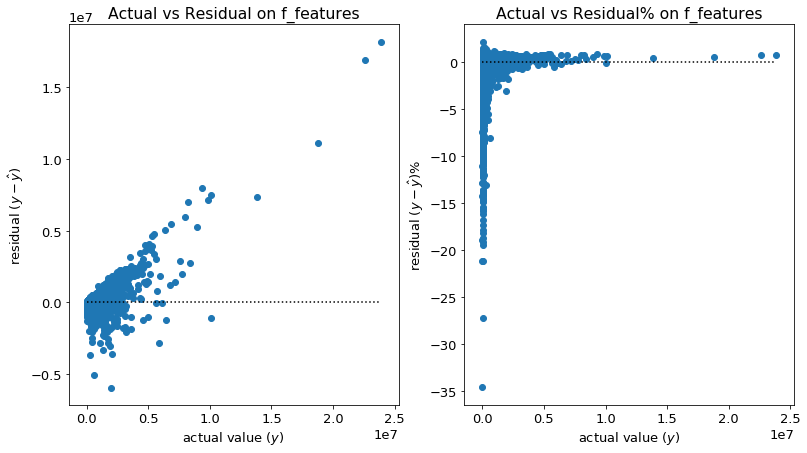

In [114]:
plt.subplot(121)
plot_residuals(y_train, lm_squared_pred_f, 'f_features')

plt.subplot(122)
plot_residuals_percentage(y_train, lm_squared_pred_f, 'f_features')

In [115]:
# Fit X_train_scaled_squared_rfe, predict and compute the rmse

lm_squared_rfe = lm_squared2.fit(X_train_scaled_squared_rfe, y_train)
lm_squared_pred_rfe = lm_squared_rfe.predict(X_train_scaled_squared_rfe)

lm_squared_rmse_rfe = mean_squared_error(y_train, lm_squared_pred_rfe)**1/2
lm_squared_rmse_rfe

122197249404.89171

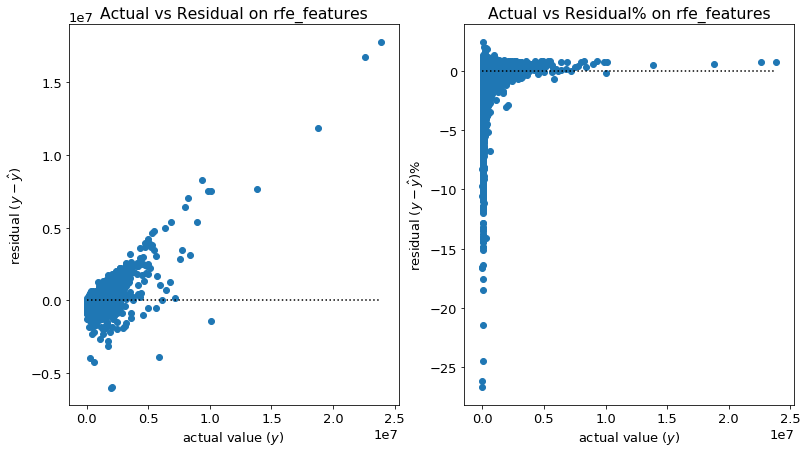

In [116]:
plt.subplot(121)
plot_residuals(y_train, lm_squared_pred_rfe, 'rfe_features')

plt.subplot(122)
plot_residuals_percentage(y_train, lm_squared_pred_rfe, 'rfe_features')

In both cases, performance on the high value outliers appears to have improved (smaller residuals), but performance on low value properties appears to have worsened (greater negative residual percentages)

## Summarize RMSE of all 6 Models

In [117]:
rmse_values = [baseline_rmse,
               lm_rmse_f, lm_rmse_rfe, 
               lars_rmse_f, lars_rmse_rfe, 
               lm_squared_rmse_f, lm_squared_rmse_rfe]
rmse_index = ['baseline_rmse',
              'lm_rmse_f', 'lm_rmse_rfe',
              'lars_rmse_f', 'lars_rmse_rfe',
              'lm_squared_rmse_f', 'lm_squared_rmse_rfe']

rmse = pd.DataFrame(rmse_values, index=rmse_index, columns=['RMSE'])
rmse.sort_values(by='RMSE')

,RMSE
lm_squared_rmse_f,1.193251e+11
lm_squared_rmse_rfe,1.221972e+11
lm_rmse_f,1.349188e+11
lars_rmse_f,1.349188e+11
lars_rmse_rfe,1.362014e+11
lm_rmse_rfe,1.362022e+11
baseline_rmse,2.292460e+11


All 6 models are outperforming the baseline, with Linear Regression with Polynomial Features (2nd Degree) using SelectKBest feature selection performing the best.

### Poly (n degress)
- f_features
- rfe_features

Because of the increased performance of the polynomial features, we will evaluate the possibility of polynomial features with greater degrees. 

In [118]:
def polyfeatures(X_train_scaled, y_train, n):
    pf = PolynomialFeatures(degree=n)
    X_train_scaled = pf.fit_transform(X_train_scaled)
    lm = LinearRegression()
    lm = lm.fit(X_train_scaled, y_train)
    lm_pred = lm.predict(X_train_scaled)
    lm_rmse = mean_squared_error(y_train, lm_pred)**1/2
    return lm_rmse

In [119]:
y_train.head()

2459     1066356.0
13744      74087.0
15417     566600.0
3257      218000.0
3093      203860.0
Name: taxvaluedollarcnt, dtype: float64

In [120]:
X_train_scaled_f.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,yearbuilt,fips_Orange
2459,0.333333,0.272727,0.133943,0.542534,0.510949,0.0
13744,0.222222,0.272727,0.081207,0.517055,0.547445,0.0
15417,0.333333,0.272727,0.174448,0.894189,0.941606,0.0
3257,0.111111,0.181818,0.036362,0.557093,0.737226,0.0
3093,0.222222,0.181818,0.048133,0.606082,0.532847,0.0


In [121]:
X_train_scaled = X_train_scaled_f

rmse_poly_n_f = []
degrees = [1,2,3,4,5,6]

for degree in degrees:
    rmse_poly_n_f.append(polyfeatures(X_train_scaled, y_train, degree))
    
rmse_poly_n_f = pd.DataFrame(rmse_poly_n_f, index=degrees, columns=['RMSE for Poly'])
rmse_poly_n_f

,RMSE for Poly
1,1.349188e+11
2,1.193251e+11
3,1.081701e+11
4,9.058231e+10
5,7.229370e+10
6,5.989166e+10


As polynomial degree increases, RMSE decreases, but we have some concern for overfitting of the data. 

In [122]:
X_train_scaled_rfe.head()

,bedroomcnt,calculatedfinishedsquarefeet,latitude,fips_Los Angeles,fips_Orange,fips_Ventura
2459,0.272727,0.133943,0.542534,1.0,0.0,0.0
13744,0.272727,0.081207,0.517055,1.0,0.0,0.0
15417,0.272727,0.174448,0.894189,1.0,0.0,0.0
3257,0.181818,0.036362,0.557093,1.0,0.0,0.0
3093,0.181818,0.048133,0.606082,1.0,0.0,0.0


In [123]:
X_train_scaled = X_train_scaled_rfe

rmse_poly_n_rfe = []
degrees = [1,2,3,4,5,6]

for degree in degrees:
    rmse_poly_n_rfe.append(polyfeatures(X_train_scaled, y_train, degree))
    
rmse_poly_n_rfe = pd.DataFrame(rmse_poly_n_rfe, index=degrees, columns=['RMSE for Poly'])
rmse_poly_n_rfe

,RMSE for Poly
1,1.362014e+11
2,1.221972e+11
3,1.176483e+11
4,1.146250e+11
5,1.075860e+11
6,9.653323e+10


It appears that SelectKBest features are still outperforming RFE selected features.

### Add Linear Regression + Polynomial Features (3rd Degree)
Because of the trend of decreased RMSE with increased polynomial degree, we will look at a 3rd degree model more specifically.

In [125]:
# Transform X_train_scaled_f and _rfe to cubed

pf3 = PolynomialFeatures(degree=3)

pf_3_f = pf3.fit(X_train_scaled_f)
X_train_scaled_cubed_f = pf3.transform(X_train_scaled_f)

pf_3_rfe = pf3.fit(X_train_scaled_rfe)
X_train_scaled_cubed_rfe = pf3.transform(X_train_scaled_rfe)

In [126]:
# Fit f_features scaled cubed dataset to LinearRegression

lm_cubed = LinearRegression()

lm_cubed_f = lm_cubed.fit(X_train_scaled_cubed_f, y_train)
lm_cubed_pred_f = lm_cubed_f.predict(X_train_scaled_cubed_f)

lm_cubed_rmse_f = mean_squared_error(y_train, lm_cubed_pred_f)**1/2
lm_cubed_rmse_f

108170149369.93448

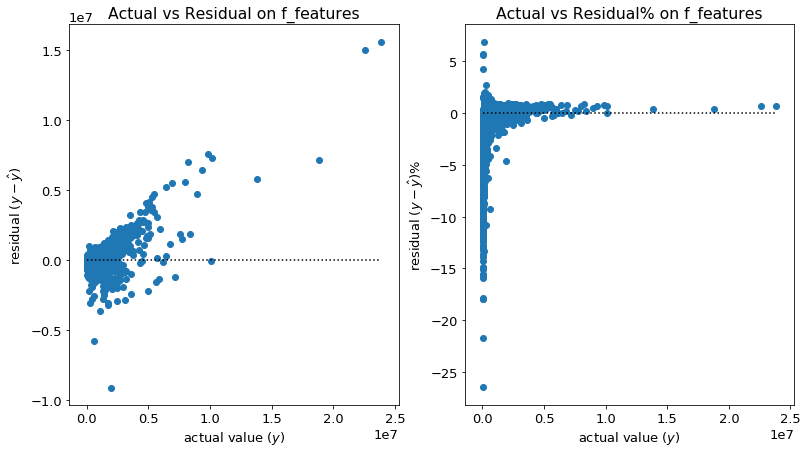

In [127]:
plt.subplot(121)
plot_residuals(y_train, lm_cubed_pred_f, 'f_features')

plt.subplot(122)
plot_residuals_percentage(y_train, lm_cubed_pred_f, 'f_features')

In [128]:
# Fit rfe_features scaled cubed dataset to LinearRegression

lm_cubed_rfe = lm_cubed.fit(X_train_scaled_cubed_rfe, y_train)
lm_cubed_pred_rfe = lm_cubed_rfe.predict(X_train_scaled_cubed_rfe)

lm_cubed_rmse_rfe = mean_squared_error(y_train, lm_cubed_pred_rfe)**1/2
lm_cubed_rmse_rfe

117648331290.71762

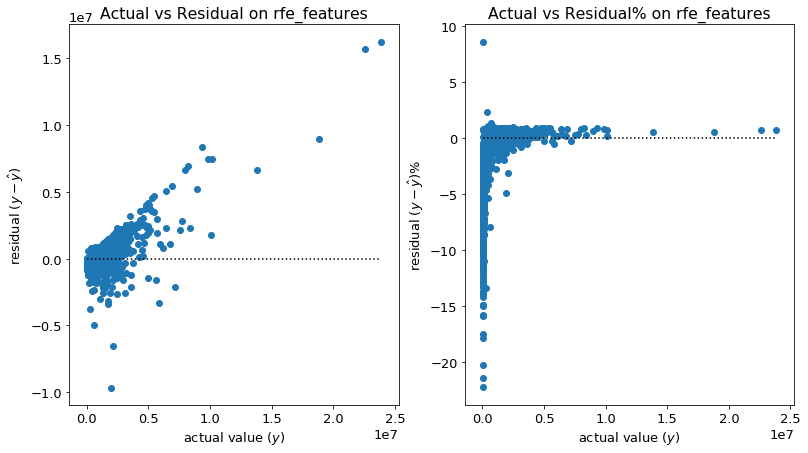

In [129]:
plt.subplot(121)
plot_residuals(y_train, lm_cubed_pred_rfe, 'rfe_features')

plt.subplot(122)
plot_residuals_percentage(y_train, lm_cubed_pred_rfe, 'rfe_features')

### Update the RMSE of all 8 models (include lm_cube_rmse)
Now that we have data for the performance of a cubed polynomial model, let's look at the performance of all of our models so far:

In [130]:
rmse_values = [baseline_rmse,
               lm_rmse_f, lm_rmse_rfe, 
               lars_rmse_f, lars_rmse_rfe, 
               lm_squared_rmse_f, lm_squared_rmse_rfe,
               lm_cubed_rmse_f, lm_cubed_rmse_rfe]
rmse_index = ['baseline_rmse',
              'lm_rmse_f', 'lm_rmse_rfe',
              'lars_rmse_f', 'lars_rmse_rfe',
              'lm_squared_rmse_f', 'lm_squared_rmse_rfe',
              'lm_cubed_rmse_f', 'lm_cubed_rmse_rfe']

rmse = pd.DataFrame(rmse_values, index=rmse_index, columns=['Train_RMSE'])
rmse.sort_values(by='Train_RMSE')

,Train_RMSE
lm_cubed_rmse_f,1.081701e+11
lm_cubed_rmse_rfe,1.176483e+11
lm_squared_rmse_f,1.193251e+11
lm_squared_rmse_rfe,1.221972e+11
lm_rmse_f,1.349188e+11
lars_rmse_f,1.349188e+11
lars_rmse_rfe,1.362014e+11
lm_rmse_rfe,1.362022e+11
baseline_rmse,2.292460e+11


### Validate Top 4 Models

To check for overfitting, we will check the performance of our top 4 models on the validate data set.

To begin, let us create scaled version of the validate sets.

In [131]:
X_validate_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3190 entries, 8847 to 7353
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   3190 non-null   float64
 1   bedroomcnt                    3190 non-null   float64
 2   calculatedfinishedsquarefeet  3190 non-null   float64
 3   latitude                      3190 non-null   float64
 4   longitude                     3190 non-null   float64
 5   lotsizesquarefeet             3190 non-null   float64
 6   yearbuilt                     3190 non-null   float64
 7   logerror                      3190 non-null   float64
 8   fips_Los Angeles              3190 non-null   float64
 9   fips_Orange                   3190 non-null   float64
 10  fips_Ventura                  3190 non-null   float64
dtypes: float64(11)
memory usage: 299.1 KB


In [132]:
X_validate_scaled.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,lotsizesquarefeet,yearbuilt,logerror,fips_Los Angeles,fips_Orange,fips_Ventura
8847,0.500000,0.454545,0.204235,0.621782,0.327459,0.002723,0.883212,0.433959,0.0,0.0,1.0
14320,0.222222,0.272727,0.062533,0.667667,0.523669,0.001627,0.576642,0.437511,1.0,0.0,0.0
16958,0.166667,0.272727,0.108561,0.591762,0.293620,0.005751,0.613139,0.440761,0.0,0.0,1.0
17680,0.111111,0.090909,0.030839,0.427750,0.524441,0.004904,0.678832,0.436007,1.0,0.0,0.0
1421,0.166667,0.363636,0.088506,0.277527,0.840811,0.002261,0.562044,0.441631,0.0,1.0,0.0


In [133]:
y_validate.head()

8847     108674.0
14320    451785.0
16958    392425.0
17680    227809.0
1421     383325.0
Name: taxvaluedollarcnt, dtype: float64

In [134]:
f_features, rfe_features

(['bathroomcnt',
  'bedroomcnt',
  'calculatedfinishedsquarefeet',
  'latitude',
  'yearbuilt',
  'fips_Orange'],
 ['bedroomcnt',
  'calculatedfinishedsquarefeet',
  'latitude',
  'fips_Los Angeles',
  'fips_Orange',
  'fips_Ventura'])

In [135]:
X_validate_scaled_f = X_validate_scaled[f_features]
X_validate_scaled_rfe = X_validate_scaled[rfe_features]

## Validating Linear Regression + Polynomial Features (3rd Degree)
- f_features
- rfe_features

In [136]:
# Transform X_validate_scaled_f and _rfe to cubed.

X_validate_scaled_cubed_f = pf3.transform(X_validate_scaled_f)
X_validate_scaled_cubed_rfe = pf3.transform(X_validate_scaled_rfe)

In [137]:
# Fit X_validate_scaled_cubed_f, predict and compute the rmse

lm_cubed_pred_f = lm_cubed_f.predict(X_validate_scaled_cubed_f)

lm_cubed_rmse_f = mean_squared_error(y_validate, lm_cubed_pred_f)**1/2
lm_cubed_rmse_f

7.089914330060167e+27

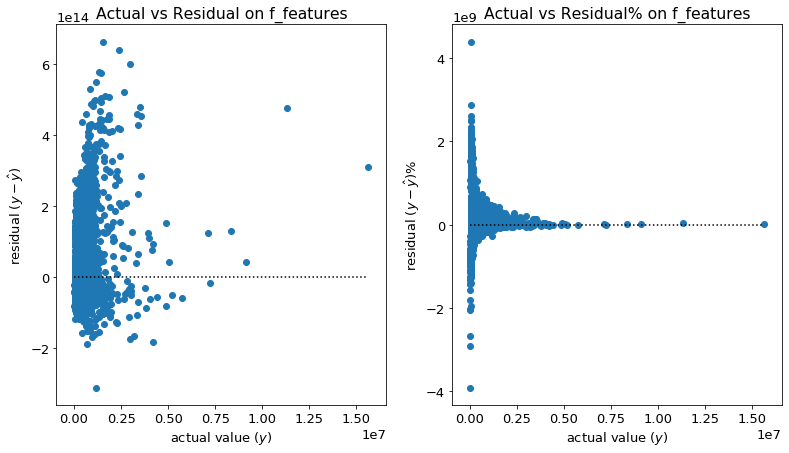

In [138]:
plt.subplot(121)
plot_residuals(y_validate, lm_cubed_pred_f, 'f_features')

plt.subplot(122)
plot_residuals_percentage(y_validate, lm_cubed_pred_f, 'f_features')

In [139]:
# Fit X_validate_scaled_squared_rfe, predict and compute the rmse

lm_cubed_pred_rfe = lm_cubed_rfe.predict(X_validate_scaled_cubed_rfe)

lm_cubed_rmse_rfe = mean_squared_error(y_validate, lm_cubed_pred_rfe)**1/2
lm_cubed_rmse_rfe

124002384354.20248

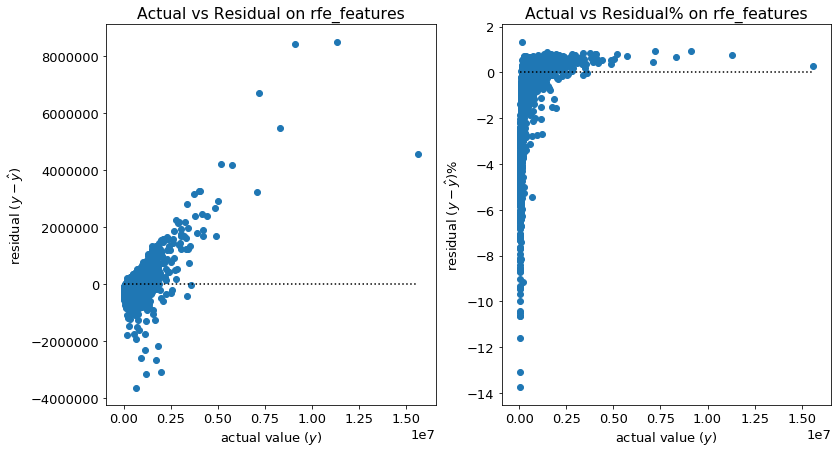

In [140]:
plt.subplot(121)
plot_residuals(y_validate, lm_cubed_pred_rfe, 'rfe_features')

plt.subplot(122)
plot_residuals_percentage(y_validate, lm_cubed_pred_rfe, 'rfe_features')

## Validating Linear Regression + Polynomial Features (2nd Degree)
- f_features
- rfe_features

In [141]:
# Transform X_validate_scaled_f and _rfe to squared.

X_validate_scaled_squared_f = pf2.transform(X_validate_scaled_f)
X_validate_scaled_squared_rfe = pf2.transform(X_validate_scaled_rfe)

In [142]:
# Fit X_validate_scaled_squared_f, predict and compute the rmse

lm_squared_pred_f = lm_squared_f.predict(X_validate_scaled_squared_f)

lm_squared_rmse_f = mean_squared_error(y_validate, lm_squared_pred_f)**1/2
lm_squared_rmse_f

4.3403183734741725e+35

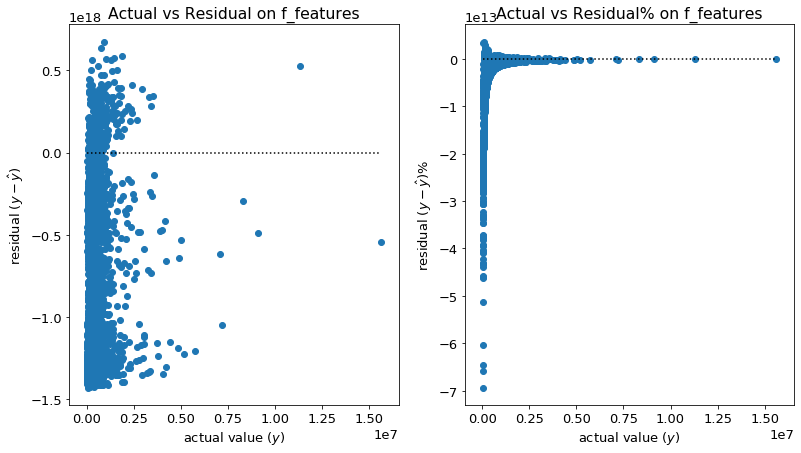

In [143]:
plt.subplot(121)
plot_residuals(y_validate, lm_squared_pred_f, 'f_features')

plt.subplot(122)
plot_residuals_percentage(y_validate, lm_squared_pred_f, 'f_features')

In [144]:
# Fit X_validate_scaled_squared_rfe, predict and compute the rmse

lm_squared_pred_rfe = lm_squared_rfe.predict(X_validate_scaled_squared_rfe)

lm_squared_rmse_rfe = mean_squared_error(y_validate, lm_squared_pred_rfe)**1/2
lm_squared_rmse_rfe

128955655829.70502

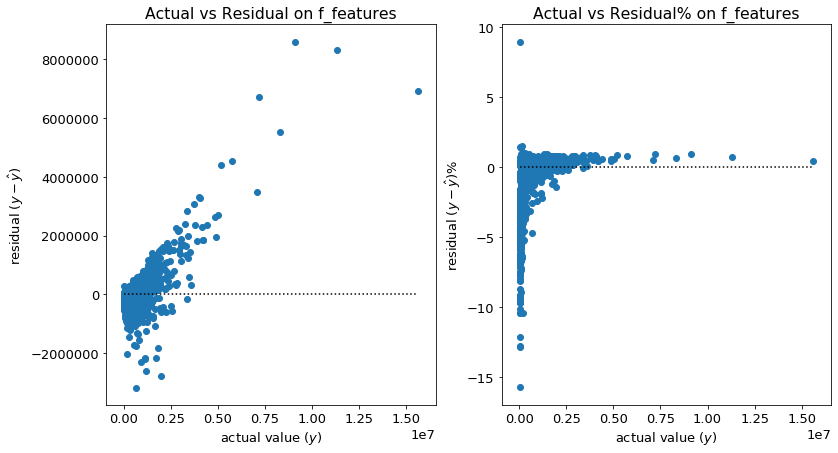

In [145]:
plt.subplot(121)
plot_residuals(y_validate, lm_squared_pred_rfe, 'f_features')

plt.subplot(122)
plot_residuals_percentage(y_validate, lm_squared_pred_rfe, 'f_features')

## Summarized RMSE Results of Validate

In [146]:
rmse_values = [baseline_rmse,
               lm_squared_rmse_f, lm_squared_rmse_rfe,
               lm_cubed_rmse_f, lm_cubed_rmse_rfe]
rmse_index = ['baseline_rmse',
              'lm_squared_rmse_f', 'lm_squared_rmse_rfe',
              'lm_cubed_rmse_f', 'lm_cubed_rmse_rfe']

rmse_validate = pd.DataFrame(rmse_values, index=rmse_index, columns=['Validate_RMSE'])
rmse_validate.sort_values(by='Validate_RMSE')

,Validate_RMSE
lm_cubed_rmse_rfe,1.240024e+11
lm_squared_rmse_rfe,1.289557e+11
baseline_rmse,2.292460e+11
lm_cubed_rmse_f,7.089914e+27
lm_squared_rmse_f,4.340318e+35


## Testing the Best Model (Linear Regression + Polynomial Features (3rd Degree))

In [147]:
# Check test dataset

X_test_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1772 entries, 7223 to 2277
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   1772 non-null   float64
 1   bedroomcnt                    1772 non-null   float64
 2   calculatedfinishedsquarefeet  1772 non-null   float64
 3   latitude                      1772 non-null   float64
 4   longitude                     1772 non-null   float64
 5   lotsizesquarefeet             1772 non-null   float64
 6   yearbuilt                     1772 non-null   float64
 7   logerror                      1772 non-null   float64
 8   fips_Los Angeles              1772 non-null   float64
 9   fips_Orange                   1772 non-null   float64
 10  fips_Ventura                  1772 non-null   float64
dtypes: float64(11)
memory usage: 166.1 KB


In [148]:
X_test_scaled.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,lotsizesquarefeet,yearbuilt,logerror,fips_Los Angeles,fips_Orange,fips_Ventura
7223,0.222222,0.363636,0.072199,0.283978,0.865605,0.002044,0.562044,0.440086,0.0,1.0,0.0
15042,0.333333,0.363636,0.150710,0.296214,0.881739,0.003014,0.627737,0.439369,0.0,1.0,0.0
14170,0.222222,0.363636,0.085679,0.358367,0.630202,0.001270,0.635036,0.427317,1.0,0.0,0.0
8692,0.277778,0.363636,0.134008,0.333382,0.743905,0.001562,0.715328,0.445995,0.0,1.0,0.0
5458,0.333333,0.454545,0.142491,0.382725,0.792408,0.002484,0.832117,0.441334,0.0,1.0,0.0


In [149]:
rfe_features

['bedroomcnt',
 'calculatedfinishedsquarefeet',
 'latitude',
 'fips_Los Angeles',
 'fips_Orange',
 'fips_Ventura']

In [150]:
X_test_scaled_rfe = X_test_scaled[rfe_features]
X_test_scaled_rfe.head()

,bedroomcnt,calculatedfinishedsquarefeet,latitude,fips_Los Angeles,fips_Orange,fips_Ventura
7223,0.363636,0.072199,0.283978,0.0,1.0,0.0
15042,0.363636,0.150710,0.296214,0.0,1.0,0.0
14170,0.363636,0.085679,0.358367,1.0,0.0,0.0
8692,0.363636,0.134008,0.333382,0.0,1.0,0.0
5458,0.454545,0.142491,0.382725,0.0,1.0,0.0


In [151]:
y_test.head()

7223       72903.0
15042    1116775.0
14170      52344.0
8692      145546.0
5458      116643.0
Name: taxvaluedollarcnt, dtype: float64

In [153]:
# Transform X_test_scaled_rfe to cubed

X_test_scaled_cubed_rfe = pf3.transform(X_test_scaled_rfe)

In [154]:
lm_cubed_pred_rfe = lm_cubed_rfe.predict(X_test_scaled_cubed_rfe)

lm_cubed_rmse_rfe = mean_squared_error(y_test, lm_cubed_pred_rfe)**1/2
lm_cubed_rmse_rfe

129888395089.45697

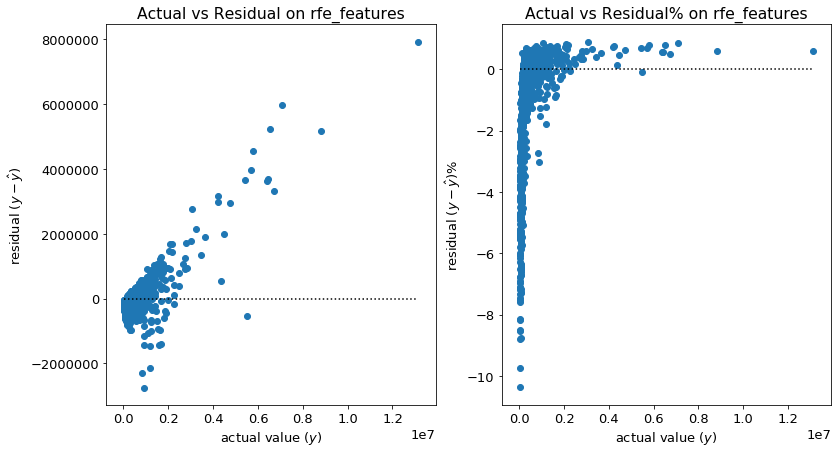

In [156]:
plt.subplot(121)
plot_residuals(y_test, lm_cubed_pred_rfe, 'rfe_features')

plt.subplot(122)
plot_residuals_percentage(y_test, lm_cubed_pred_rfe, 'rfe_features')

In [158]:
rmse_values = [baseline_rmse,lm_cubed_rmse_rfe]
rmse_index = ['baseline_rmse','lm_cubed_rmse_rfe']

rmse_test = pd.DataFrame(rmse_values, index=rmse_index, columns=['Test_RMSE'])
rmse_test.sort_values(by='Test_RMSE')

,Test_RMSE
lm_cubed_rmse_rfe,1.298884e+11
baseline_rmse,2.292460e+11


In [159]:
rmse_overall = pd.concat([rmse, rmse_validate], axis=1)
rmse_overall = pd.concat([rmse_overall, rmse_test], axis=1)

rmse_overall.sort_values(by='Train_RMSE')

,Train_RMSE,Validate_RMSE,Test_RMSE
lm_cubed_rmse_f,1.081701e+11,7.089914e+27,NaN
lm_cubed_rmse_rfe,1.176483e+11,1.240024e+11,1.298884e+11
lm_squared_rmse_f,1.193251e+11,4.340318e+35,NaN
lm_squared_rmse_rfe,1.221972e+11,1.289557e+11,NaN
lm_rmse_f,1.349188e+11,NaN,NaN
lars_rmse_f,1.349188e+11,NaN,NaN
lars_rmse_rfe,1.362014e+11,NaN,NaN
lm_rmse_rfe,1.362022e+11,NaN,NaN
baseline_rmse,2.292460e+11,2.292460e+11,2.292460e+11


In [164]:
import statistics

def median_percentage_error(actual, predicted):
    """
    Returns the median error of the residuals
    Parameters: actual y(df.se), predicted y(df.se)
    """
    residuals = actual - predicted
    residuals_percentage = residuals/actual * 100
    median_error = statistics.median(residuals_percentage)
    return median_error

In [165]:
print(median_percentage_error(y_test, lm_cubed_pred_rfe))

-7.470136657488412


# Conclusion
- The properties in this data set come from Los Angeles County, Orange County, and Ventura County -- all of which are located in the state of California.
- The mean tax rate is about 15% higher in Los Angeles county than in Orange or Ventura counties.
- Like tax value, the tax rate is positively skewed by a small number of significantly high rates. 
- While there is a large range of tax rates, most tax rates fall between 1 and 2 percent.
- By using recursive feature elimination to select the best 6 features out of the data (given our considerations for which original features needed to be dropped), we developed a model using the following features:
    - `bedroomcnt`, `calculatedfinishedsquarefeet`, `latitude`, `fips_Los Angeles`, `fips_Orange`, `fips_Ventura`
- Compared to the a featureless baseline model using only the mean `taxvaluedollarcnt`, our model had 56% as much root mean squared error.
- With additional time, further exploration of features could be performed. Binning categorical features with a large number of unique values into relevant supercategories could prove useful. Additional changes to hyperparameters may also improve performance.
- The model performs best on midrange homes, but has the weakest performance on low value properties. This is likely due to the influence of high value outliers. The model could be improved on its performance on lower value properties (which also make up a larger proportion of the overall property distribution relative to the higher value properties) by removing outliers or using a scaling method that is more robust to outliers.
- Some limitations of the model are based on the use of tax valuation itself. While tax value is updated on a yearly basis in the area, California Proposition 13 limits increases to the valuation of a property to 2% per year. If actual home values based on sales and purchases are trending higher at faster than 2% per year, the data will be unable to accuractely capture the increased property value. 